In [1]:
from tensorflow import keras
import pickle
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import seaborn as sns
import pickle
import functools
import fastdtw
import scipy.spatial.distance as sd
import functools
import matplotlib.pyplot as plt
import seaborn as sns

2022-05-15 23:01:41.813468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-15 23:01:41.813513: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Importing solar and wind dataframes
solar_df = pd.read_csv('Final Datasets/solar_energy_generation.csv')
wind_df = pd.read_csv('Final Datasets/wind_energy_generation.csv')

In [3]:
# Removing unnecessary columns
solar_df = solar_df[['timestamp', 'GHI_KWh',
       'Clearsky GHI_KWh', 'Solar Energy', 'Clearsky Solar Energy']]
# Renaming columns for the lineplot
solar_df.rename(columns = {'GHI_KWh':'Global Horizontal Irradiance',
                          'Clearsky GHI_KWh': 'Clearsky Global Horizontal Irradiance'}, inplace = True)
# Converting timestamp from string to pd.datetime format
solar_df['timestamp'] = pd.to_datetime(solar_df['timestamp'])
# Limiting solar dataset to 2017
solar_df = solar_df[solar_df['timestamp'] >= pd.Timestamp("2017-01-01 00:00:00")]
solar_df = solar_df[solar_df['timestamp'] < pd.Timestamp("2018-01-01 00:00:00")]
# Setting the index to timestamp
solar_df = solar_df.set_index('timestamp')
solar_df

Global Horizontal Irradiance  \
timestamp                                           
2017-01-01 00:00:00                           0.0   
2017-01-01 00:30:00                           0.0   
2017-01-01 01:00:00                           0.0   
2017-01-01 01:30:00                           0.0   
2017-01-01 02:00:00                           0.0   
...                                           ...   
2017-12-31 21:30:00                           0.0   
2017-12-31 22:00:00                           0.0   
2017-12-31 22:30:00                           0.0   
2017-12-31 23:00:00                           0.0   
2017-12-31 23:30:00                           0.0   

                     Clearsky Global Horizontal Irradiance  Solar Energy  \
timestamp                                                                  
2017-01-01 00:00:00                                    0.0           0.0   
2017-01-01 00:30:00                                    0.0           0.0   
2017-01-01 01:00:00                                    0.0           0.0   
2017-01-01 01:30:00                                    0.0           0.0   
2017-01-01 02:00:00                                    0.0           0.0   
...                                                    ...           ...   
2017-12-31 21:30:00                                    0.0           0.0   
2017-12-31 22:00:00                                    0.0           0.0   
2017-12-31 22:30:00                                    0.0           0.0   
2017-12-31 23:00:00                                    0.0           0.0   
2017-12-31 23:30:00                                    0.0           0.0   

                     Clearsky Solar Energy  
timestamp                                   
2017-01-01 00:00:00                    0.0  
2017-01-01 00:30:00                    0.0  
2017-01-01 01:00:00                    0.0  
2017-01-01 01:30:00                    0.0  
2017-01-01 02:00:00                    0.0  
...                                    ...  
2017-12-31 21:30:00                    0.0  
2017-12-31 22:00:00                    0.0  
2017-12-31 22:30:00                    0.0  
2017-12-31 23:00:00                    0.0  
2017-12-31 23:30:00                    0.0  

[17520 rows x 4 columns]

In [4]:
# I have used this post on Stackoverflow to plot multiple graphs 
# https://stackoverflow.com/a/38305181
def plot_solar(df, size=(8, 6)):
    figs = {}
    axs = {}
    for idx, feature in enumerate(df.keys()):
        figs[idx] = plt.figure(figsize = size)
        axs[idx] = figs[idx].add_subplot(111)
        axs[idx].plot(df[feature], label=feature)
        axs[idx].set_xlabel('Timestamp')
        axs[idx].set_ylabel('KWh')
        axs[idx].legend()
    return figs, axs

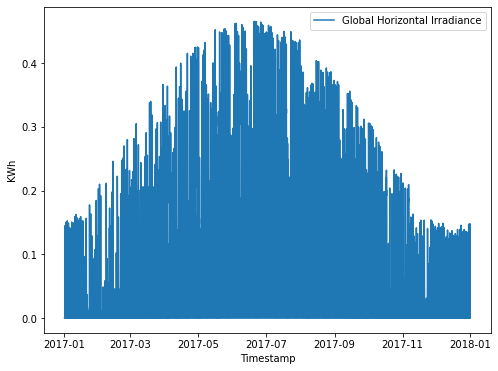

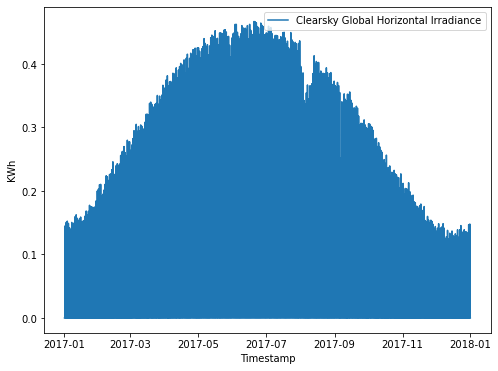

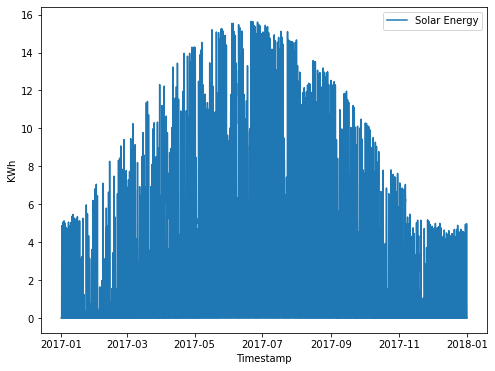

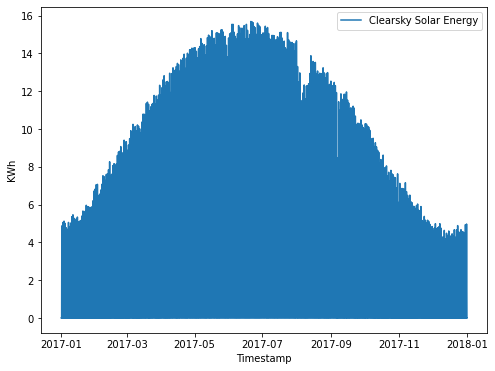

In [5]:
# Plotting line graphs on an annual scale
figs, axs = plot_solar(solar_df)

In [6]:
# Aggregating solar df to weekly datapoints and summing values for each week
solar_df
#solar_weekly_df = solar_df.resample('D').sum()
solar_weekly_df = solar_df.resample('W').sum()
solar_weekly_df.head()

Global Horizontal Irradiance  \
timestamp                                  
2017-01-01                        1.4260   
2017-01-08                       10.2445   
2017-01-15                       11.1875   
2017-01-22                        6.9185   
2017-01-29                        6.8310   

            Clearsky Global Horizontal Irradiance  Solar Energy  \
timestamp                                                         
2017-01-01                                 1.4260       47.9136   
2017-01-08                                10.2445      344.2152   
2017-01-15                                11.1875      375.9000   
2017-01-22                                11.6970      232.4616   
2017-01-29                                13.4020      229.5216   

            Clearsky Solar Energy  
timestamp                          
2017-01-01                47.9136  
2017-01-08               344.2152  
2017-01-15               375.9000  
2017-01-22               393.0192  
2017-01-29               450.3072

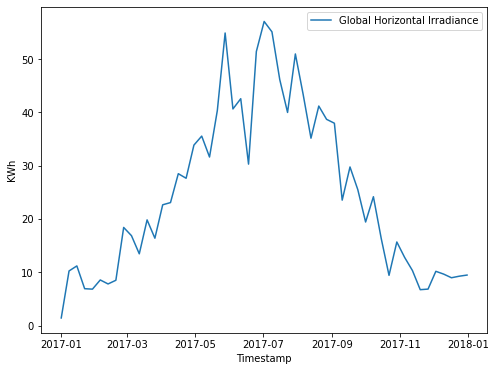

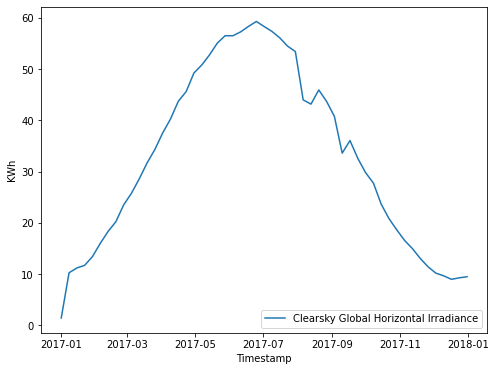

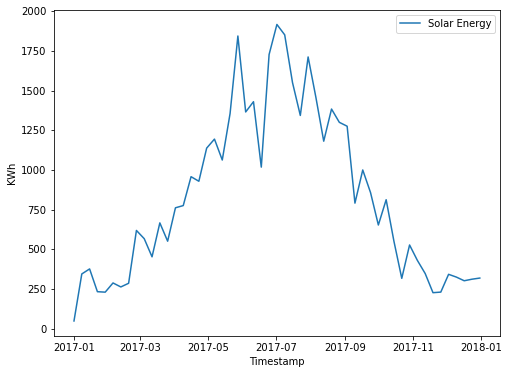

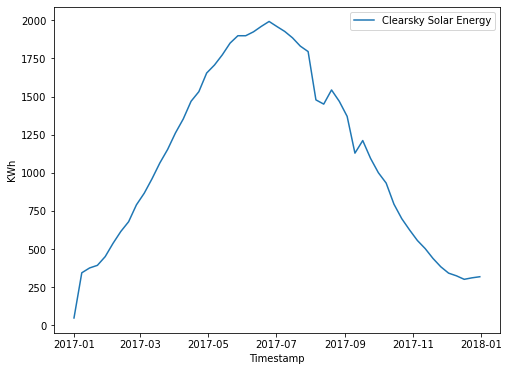

In [7]:
# Plotting annual line graphs with aggregated weekly datapoints
figs, axs = plot_solar(solar_weekly_df)

In [8]:
# Limiting solar df to Nov 2017: November 2017 Energy Consumption values are common for all houses except 4
solar_df = solar_df[solar_df.index >= pd.Timestamp("2017-11-01 00:00:00")]
solar_df = solar_df[solar_df.index < pd.Timestamp("2017-12-01 00:00:00")]
solar_df

Global Horizontal Irradiance  \
timestamp                                           
2017-11-01 00:00:00                           0.0   
2017-11-01 00:30:00                           0.0   
2017-11-01 01:00:00                           0.0   
2017-11-01 01:30:00                           0.0   
2017-11-01 02:00:00                           0.0   
...                                           ...   
2017-11-30 21:30:00                           0.0   
2017-11-30 22:00:00                           0.0   
2017-11-30 22:30:00                           0.0   
2017-11-30 23:00:00                           0.0   
2017-11-30 23:30:00                           0.0   

                     Clearsky Global Horizontal Irradiance  Solar Energy  \
timestamp                                                                  
2017-11-01 00:00:00                                    0.0           0.0   
2017-11-01 00:30:00                                    0.0           0.0   
2017-11-01 01:00:00                                    0.0           0.0   
2017-11-01 01:30:00                                    0.0           0.0   
2017-11-01 02:00:00                                    0.0           0.0   
...                                                    ...           ...   
2017-11-30 21:30:00                                    0.0           0.0   
2017-11-30 22:00:00                                    0.0           0.0   
2017-11-30 22:30:00                                    0.0           0.0   
2017-11-30 23:00:00                                    0.0           0.0   
2017-11-30 23:30:00                                    0.0           0.0   

                     Clearsky Solar Energy  
timestamp                                   
2017-11-01 00:00:00                    0.0  
2017-11-01 00:30:00                    0.0  
2017-11-01 01:00:00                    0.0  
2017-11-01 01:30:00                    0.0  
2017-11-01 02:00:00                    0.0  
...                                    ...  
2017-11-30 21:30:00                    0.0  
2017-11-30 22:00:00                    0.0  
2017-11-30 22:30:00                    0.0  
2017-11-30 23:00:00                    0.0  
2017-11-30 23:30:00                    0.0  

[1440 rows x 4 columns]

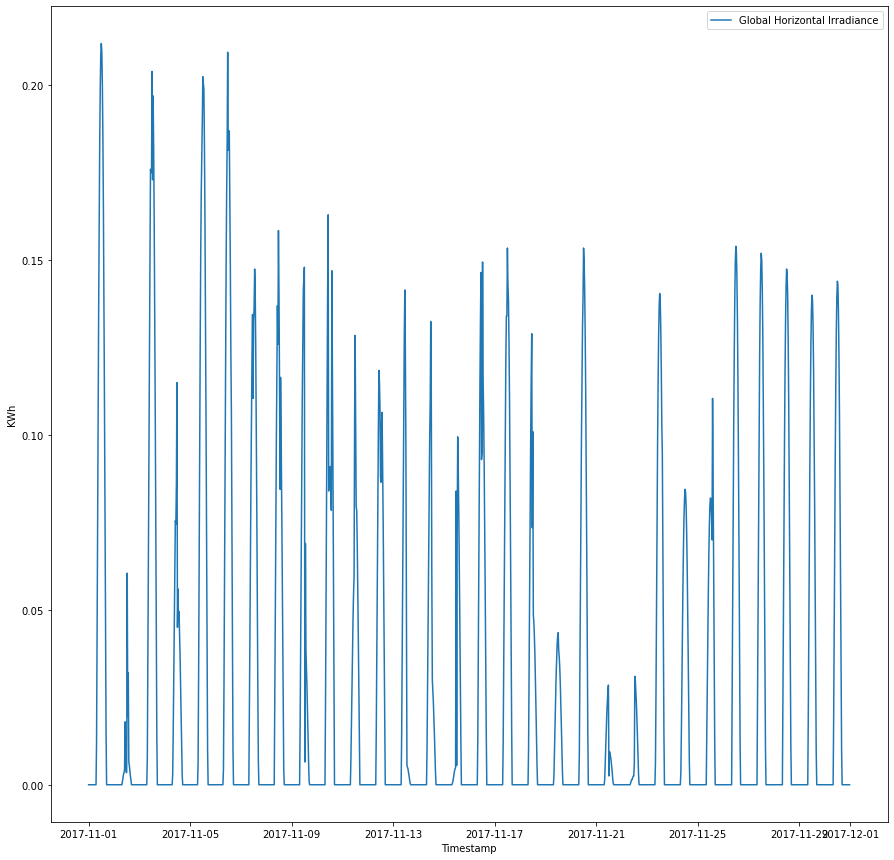

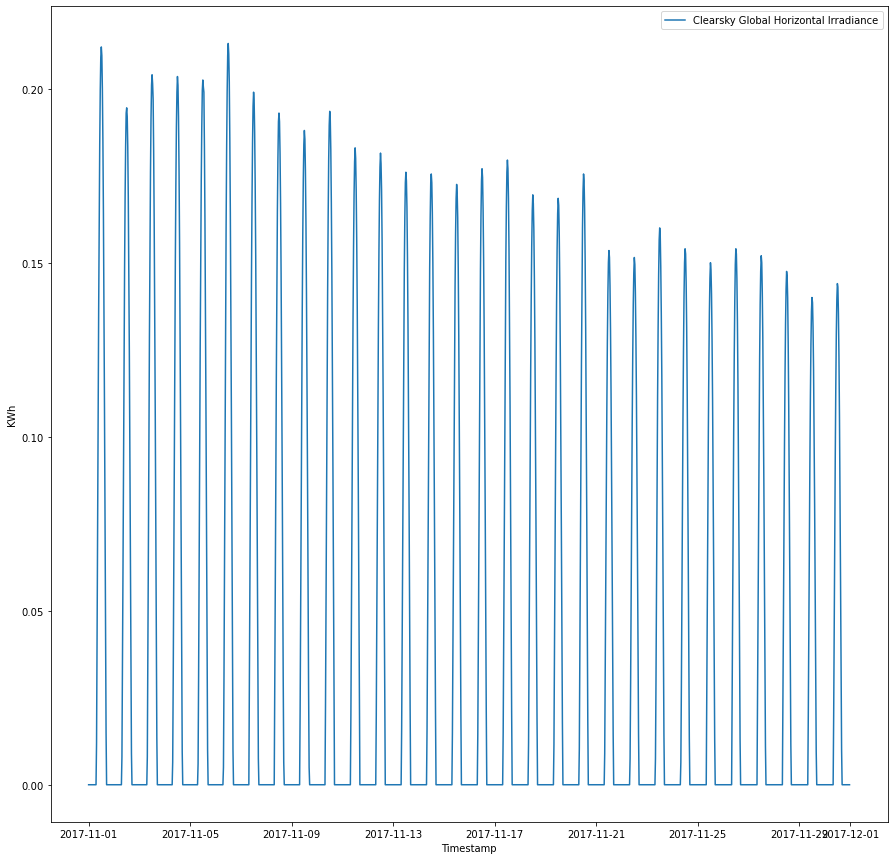

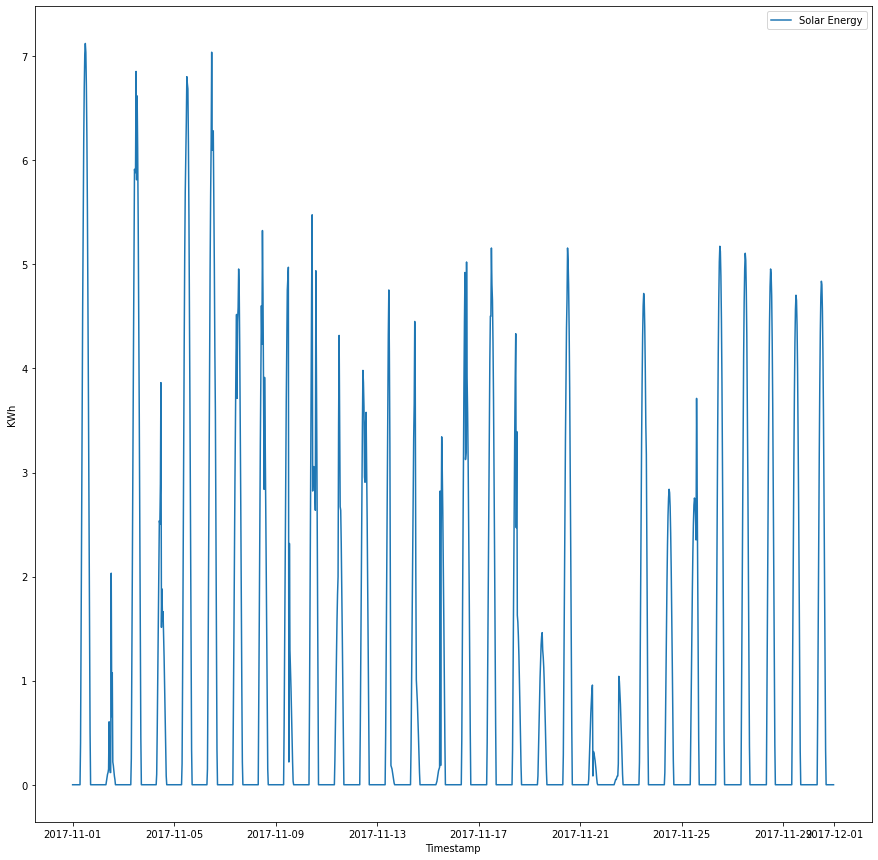

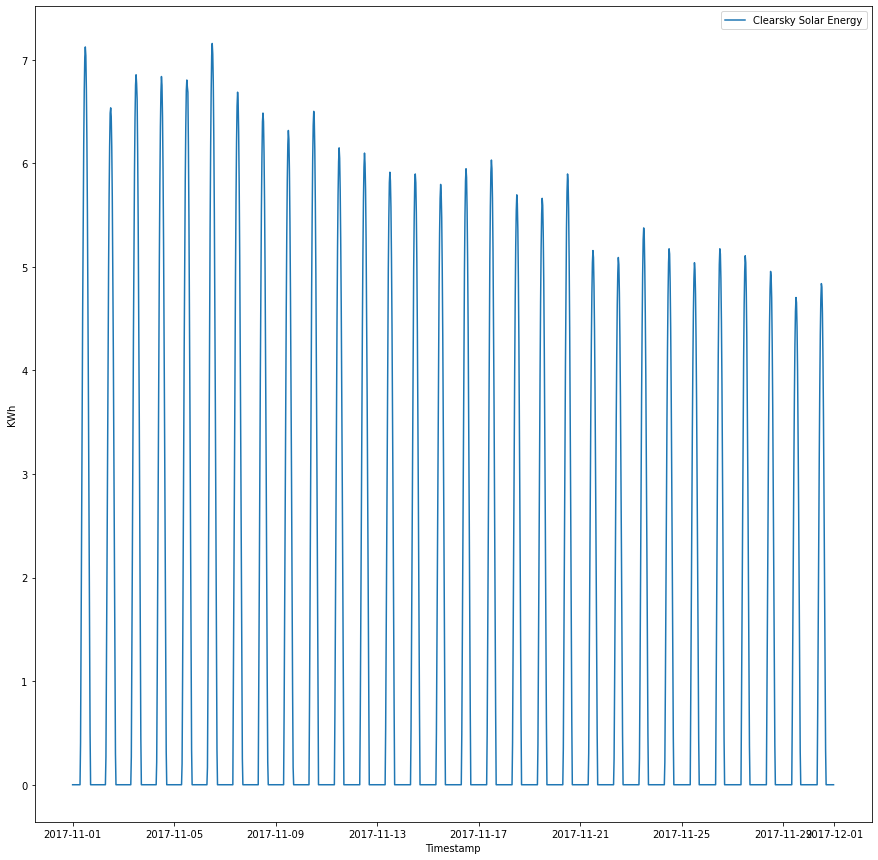

In [9]:
# Plotting line graphs for December 2017
figs, axs = plot_solar(solar_df, (15,15))

In [10]:
# Aggregating data points at every 6 hours
solar_df
solar_six_hour_df = solar_df.resample('6H').sum()
solar_six_hour_df

Global Horizontal Irradiance  \
timestamp                                           
2017-11-01 00:00:00                        0.0000   
2017-11-01 06:00:00                        1.1240   
2017-11-01 12:00:00                        1.3525   
2017-11-01 18:00:00                        0.0000   
2017-11-02 00:00:00                        0.0000   
...                                           ...   
2017-11-29 18:00:00                        0.0000   
2017-11-30 00:00:00                        0.0000   
2017-11-30 06:00:00                        0.6115   
2017-11-30 12:00:00                        0.8365   
2017-11-30 18:00:00                        0.0000   

                     Clearsky Global Horizontal Irradiance  Solar Energy  \
timestamp                                                                  
2017-11-01 00:00:00                                 0.0000        0.0000   
2017-11-01 06:00:00                                 1.1240       37.7664   
2017-11-01 12:00:00                                 1.3525       45.4440   
2017-11-01 18:00:00                                 0.0000        0.0000   
2017-11-02 00:00:00                                 0.0000        0.0000   
...                                                    ...           ...   
2017-11-29 18:00:00                                 0.0000        0.0000   
2017-11-30 00:00:00                                 0.0000        0.0000   
2017-11-30 06:00:00                                 0.6115       20.5464   
2017-11-30 12:00:00                                 0.8365       28.1064   
2017-11-30 18:00:00                                 0.0000        0.0000   

                     Clearsky Solar Energy  
timestamp                                   
2017-11-01 00:00:00                 0.0000  
2017-11-01 06:00:00                37.7664  
2017-11-01 12:00:00                45.4440  
2017-11-01 18:00:00                 0.0000  
2017-11-02 00:00:00                 0.0000  
...                                    ...  
2017-11-29 18:00:00                 0.0000  
2017-11-30 00:00:00                 0.0000  
2017-11-30 06:00:00                20.5464  
2017-11-30 12:00:00                28.1064  
2017-11-30 18:00:00                 0.0000  

[120 rows x 4 columns]

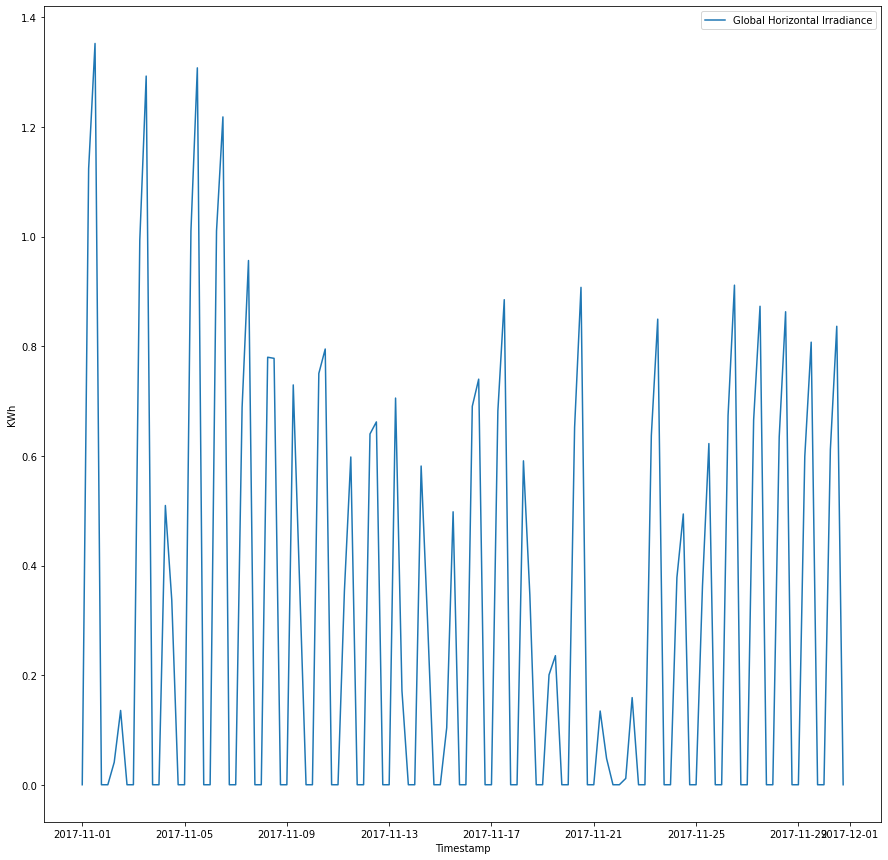

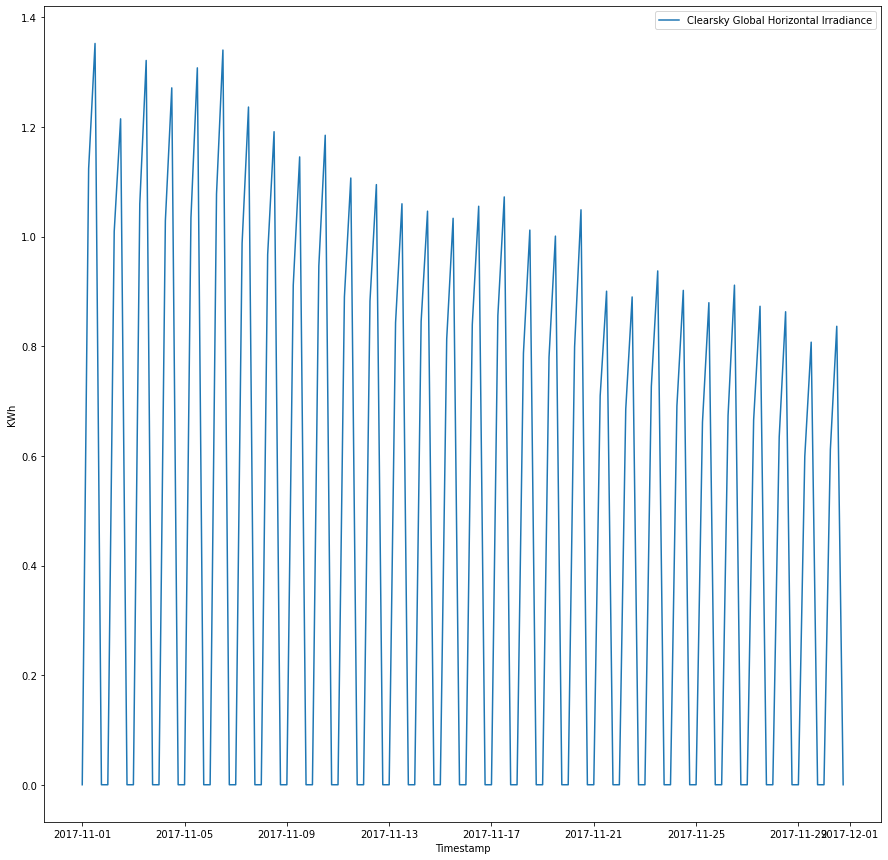

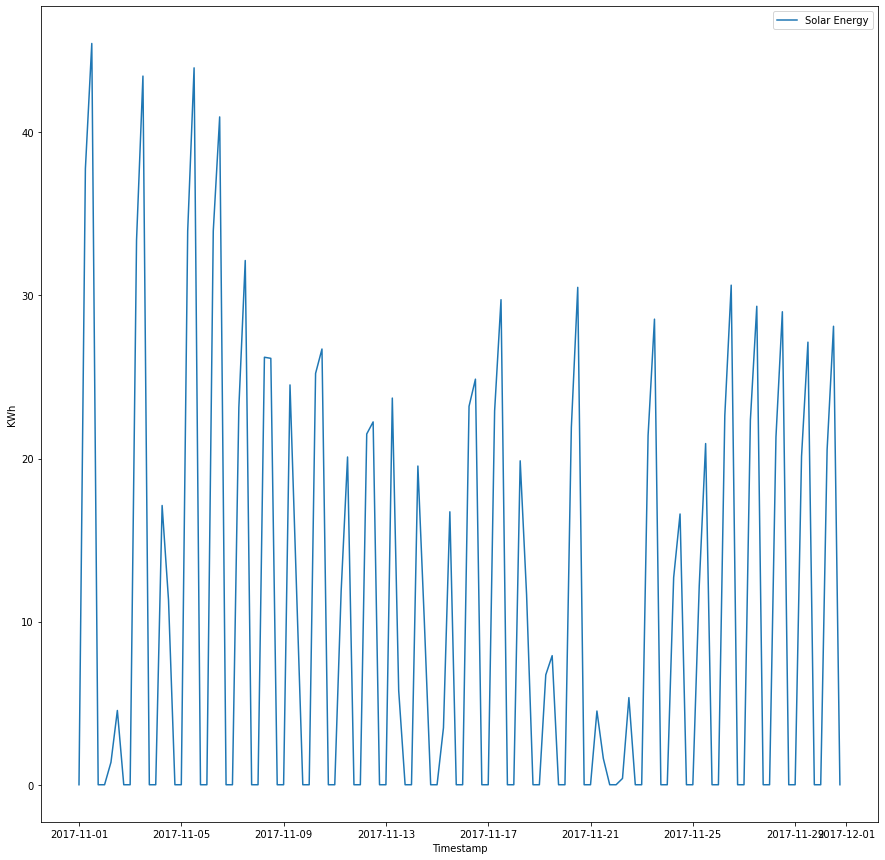

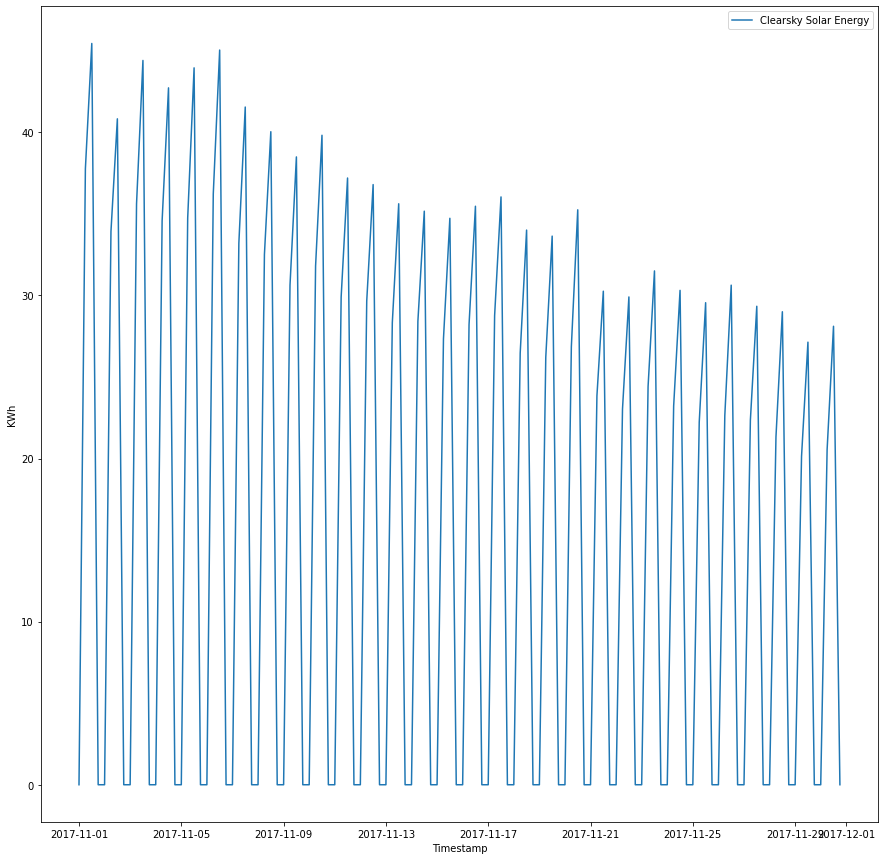

In [11]:
# Plotting monthly line graphs with aggregated datapoints
figs, axs = plot_solar(solar_six_hour_df, (15,15))

### Wind Dataframe Graphs

In [12]:
wind_df

Unnamed: 0            timestamp  Pressure  Temperature  Wind Speed  \
0                0  2012-01-01 00:00:00    102000       275.15         0.5   
1                1  2012-01-01 00:30:00    102000       275.15         0.5   
2                2  2012-01-01 01:00:00    102000       275.15         0.5   
3                3  2012-01-01 01:30:00    102000       275.15         0.5   
4                4  2012-01-01 02:00:00    102000       275.15         0.5   
...            ...                  ...       ...          ...         ...   
157819      157819  2020-12-31 21:30:00    100200       282.95         1.0   
157820      157820  2020-12-31 22:00:00    100200       283.05         1.0   
157821      157821  2020-12-31 22:30:00    100200       283.05         1.0   
157822      157822  2020-12-31 23:00:00    100200       282.95         1.0   
157823      157823  2020-12-31 23:30:00    100300       282.85         1.0   

        Air Density    Wind Power  Wind Energy  
0          1.291401   4711.409041     2.355705  
1          1.291401   4711.409041     2.355705  
2          1.291401   4711.409041     2.355705  
3          1.291401   4711.409041     2.355705  
4          1.291401   4711.409041     2.355705  
...             ...           ...          ...  
157819     1.233640  36005.443653    18.002722  
157820     1.233204  35992.723129    17.996362  
157821     1.233204  35992.723129    17.996362  
157822     1.233640  36005.443653    18.002722  
157823     1.235308  36054.119452    18.027060  

[157824 rows x 8 columns]

In [13]:
# Removing unnecessary columns
wind_df = wind_df[['timestamp', 'Pressure', 'Temperature', 'Wind Speed',
       'Air Density', 'Wind Power', 'Wind Energy']]
# Units of the features in the dataframe for y-labels
wind_feature_units = {'timestamp': 'time', 'Pressure':'Pa', 'Temperature':'Kelvin', 'Wind Speed':'m/s',
       'Air Density':'kg/m^3', 'Wind Power':'Watt', 'Wind Energy':'KWh'}
# Converting timestamp from string to pd.datetime format
wind_df['timestamp'] = pd.to_datetime(wind_df['timestamp'])
# Limiting wind dataset to 2017
wind_df = wind_df[wind_df['timestamp'] >= pd.Timestamp("2017-01-01 00:00:00")]
wind_df = wind_df[wind_df['timestamp'] < pd.Timestamp("2018-01-01 00:00:00")]
# Setting the index to timestamp
wind_df = wind_df.set_index('timestamp')
wind_df

/tmp/ipykernel_11348/2739560884.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_df['timestamp'] = pd.to_datetime(wind_df['timestamp'])


Pressure  Temperature  Wind Speed  Air Density  \
timestamp                                                             
2017-01-01 00:00:00    101000       272.15         0.7     1.292836   
2017-01-01 00:30:00    101000       272.15         0.7     1.292836   
2017-01-01 01:00:00    101000       272.15         0.7     1.292836   
2017-01-01 01:30:00    101000       272.15         0.7     1.292836   
2017-01-01 02:00:00    101000       272.15         0.8     1.292836   
...                       ...          ...         ...          ...   
2017-12-31 21:30:00    101000       273.15         0.7     1.288103   
2017-12-31 22:00:00    101000       272.15         0.8     1.292836   
2017-12-31 22:30:00    101000       272.15         0.7     1.292836   
2017-12-31 23:00:00    101000       272.15         0.7     1.292836   
2017-12-31 23:30:00    101000       272.15         0.7     1.292836   

                       Wind Power  Wind Energy  
timestamp                                       
2017-01-01 00:00:00  12942.473920     6.471237  
2017-01-01 00:30:00  12942.473920     6.471237  
2017-01-01 01:00:00  12942.473920     6.471237  
2017-01-01 01:30:00  12942.473920     6.471237  
2017-01-01 02:00:00  19319.377979     9.659689  
...                           ...          ...  
2017-12-31 21:30:00  12895.091624     6.447546  
2017-12-31 22:00:00  19319.377979     9.659689  
2017-12-31 22:30:00  12942.473920     6.471237  
2017-12-31 23:00:00  12942.473920     6.471237  
2017-12-31 23:30:00  12942.473920     6.471237  

[17520 rows x 6 columns]

In [14]:
# I have used this post on Stackoverflow to plot multiple graphs 
# https://stackoverflow.com/a/38305181
def plot_wind(df, units, size=(8, 6)):
    figs = {}
    axs = {}
    for idx, feature in enumerate(df.keys()):
        figs[idx] = plt.figure(figsize = size)
        axs[idx] = figs[idx].add_subplot(111)
        axs[idx].plot(df[feature], label=feature)
        axs[idx].set_xlabel('Timestamp')
        axs[idx].set_ylabel(units[feature])
        axs[idx].legend()
    return figs, axs

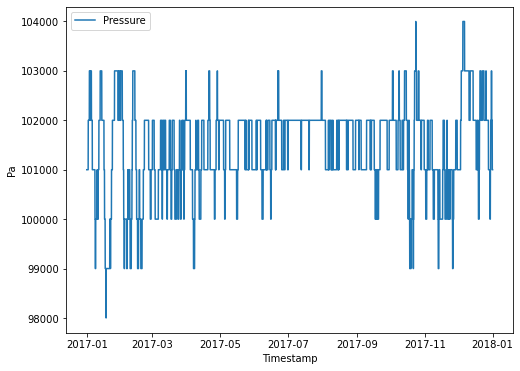

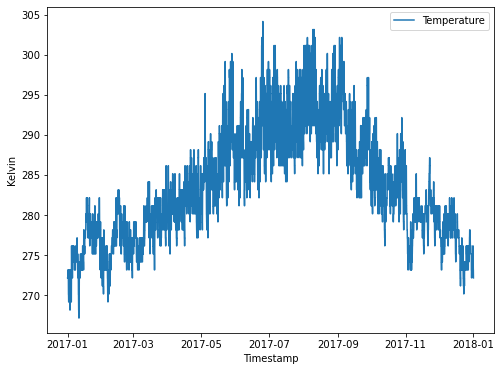

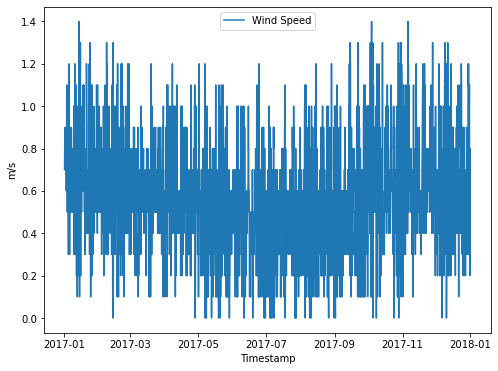

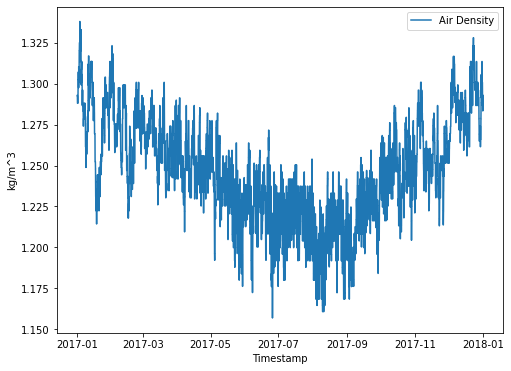

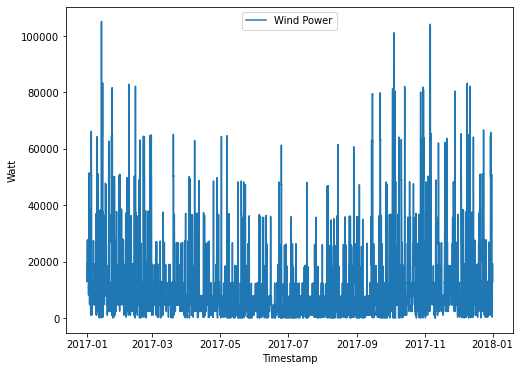

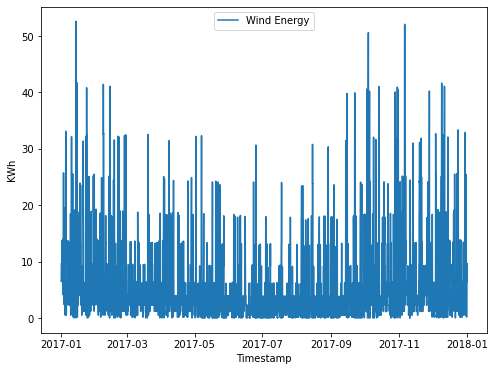

In [15]:
# Plotting line graphs on an annual scale
figs, axs = plot_wind(wind_df, wind_feature_units)

In [16]:
# Aggregating wind df to weekly datapoints and summing values for each week

wind_weekly_df = wind_df.resample('W').sum()
# Removing the first row because of incorrect values 
wind_weekly_df = wind_weekly_df.iloc[1: , :]

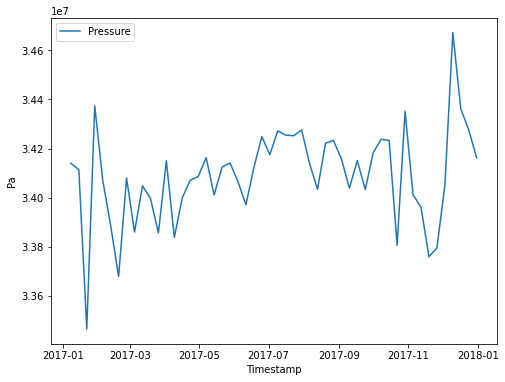

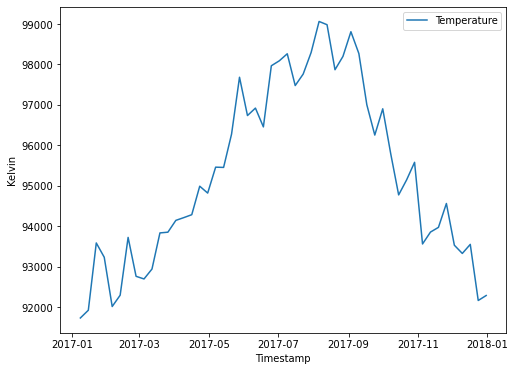

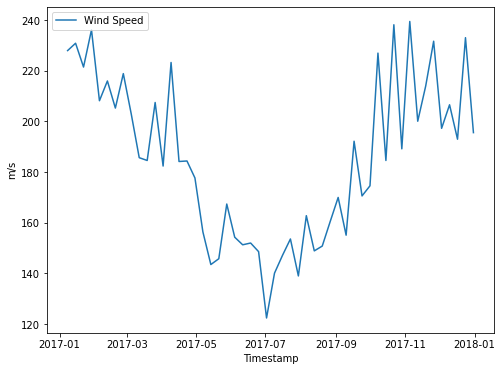

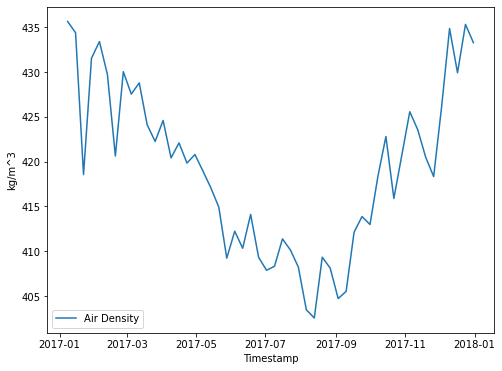

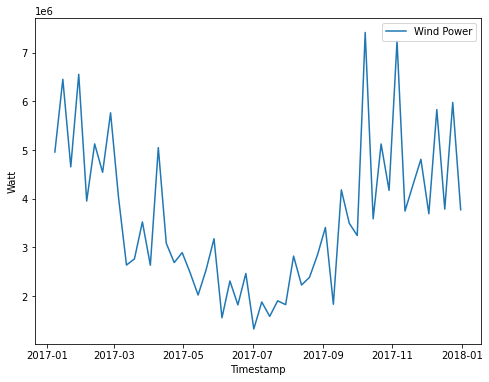

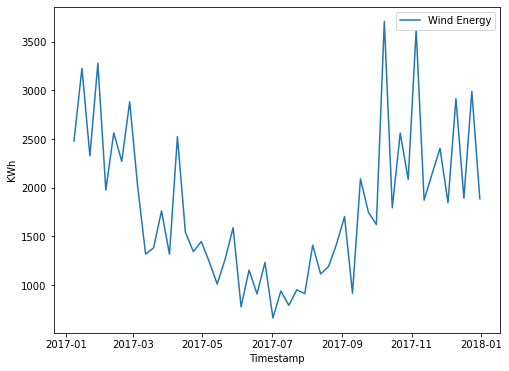

In [17]:
# Plotting annual line graphs with aggregated weekly datapoints
figs, axs = plot_wind(wind_weekly_df, wind_feature_units)

In [18]:
# Limiting wind df to November 2017
wind_df = wind_df[wind_df.index >= pd.Timestamp("2017-11-01 00:00:00")]
wind_df = wind_df[wind_df.index < pd.Timestamp("2018-12-01 00:00:00")]
wind_df

Pressure  Temperature  Wind Speed  Air Density  \
timestamp                                                             
2017-11-01 00:00:00    101000       281.15         0.7     1.251450   
2017-11-01 00:30:00    101000       280.15         0.7     1.255917   
2017-11-01 01:00:00    101000       280.15         0.7     1.255917   
2017-11-01 01:30:00    101000       280.15         0.7     1.255917   
2017-11-01 02:00:00    101000       280.15         0.8     1.255917   
...                       ...          ...         ...          ...   
2017-12-31 21:30:00    101000       273.15         0.7     1.288103   
2017-12-31 22:00:00    101000       272.15         0.8     1.292836   
2017-12-31 22:30:00    101000       272.15         0.7     1.292836   
2017-12-31 23:00:00    101000       272.15         0.7     1.292836   
2017-12-31 23:30:00    101000       272.15         0.7     1.292836   

                       Wind Power  Wind Energy  
timestamp                                       
2017-11-01 00:00:00  12528.167445     6.264084  
2017-11-01 00:30:00  12572.886943     6.286443  
2017-11-01 01:00:00  12572.886943     6.286443  
2017-11-01 01:30:00  12572.886943     6.286443  
2017-11-01 02:00:00  18767.691298     9.383846  
...                           ...          ...  
2017-12-31 21:30:00  12895.091624     6.447546  
2017-12-31 22:00:00  19319.377979     9.659689  
2017-12-31 22:30:00  12942.473920     6.471237  
2017-12-31 23:00:00  12942.473920     6.471237  
2017-12-31 23:30:00  12942.473920     6.471237  

[2928 rows x 6 columns]

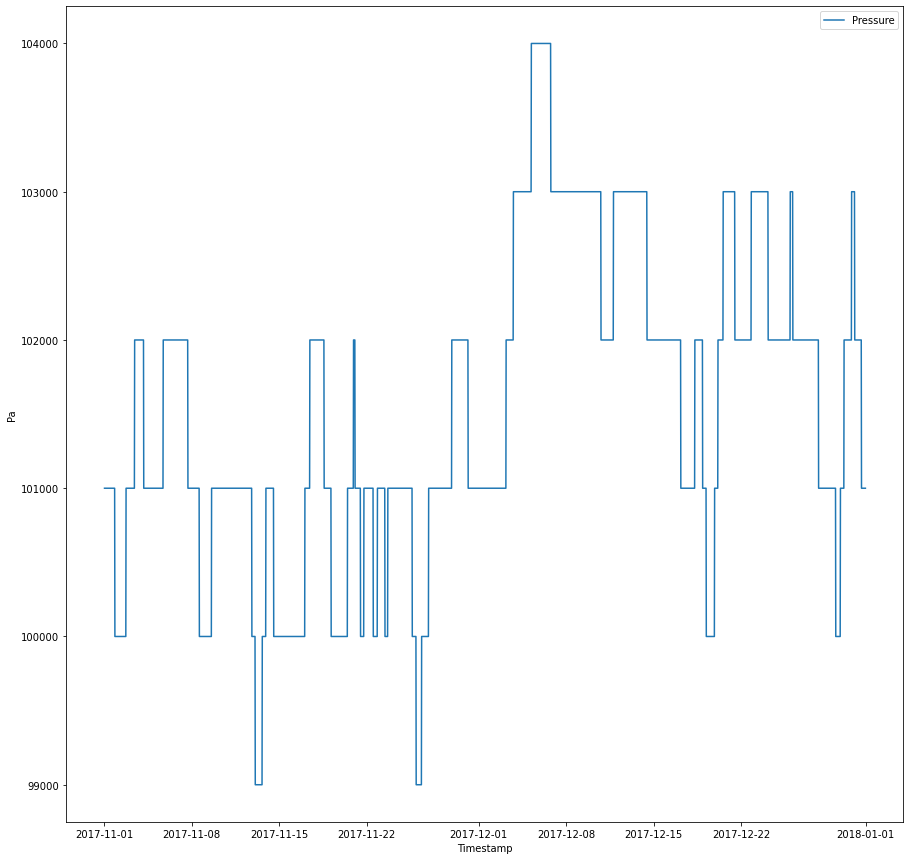

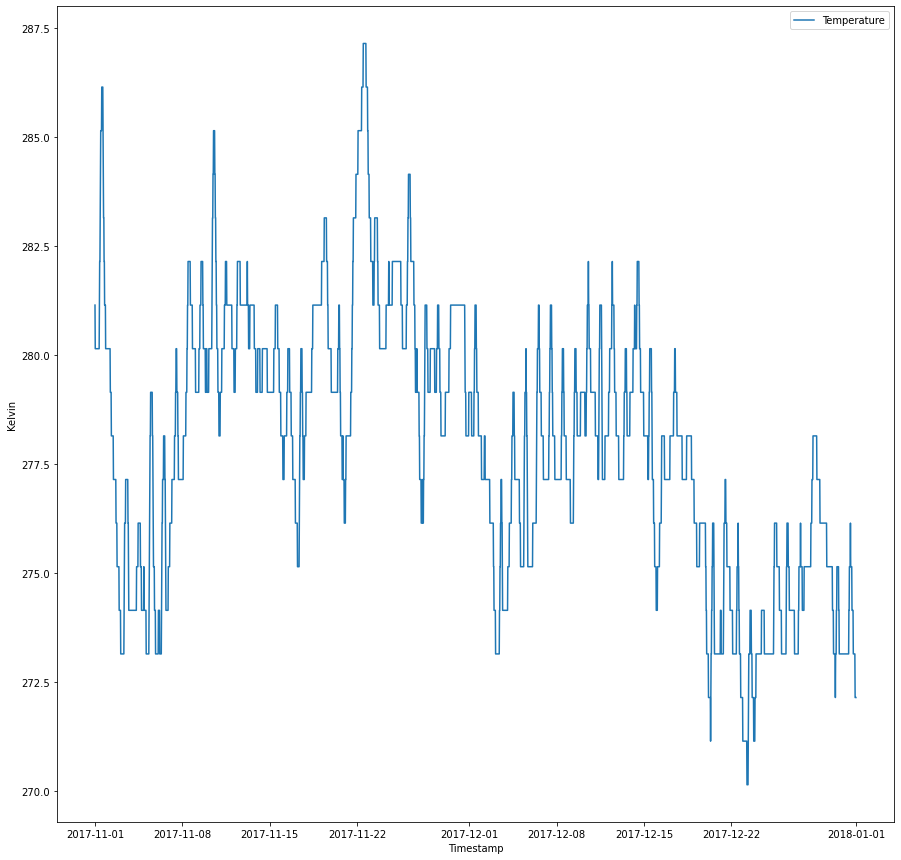

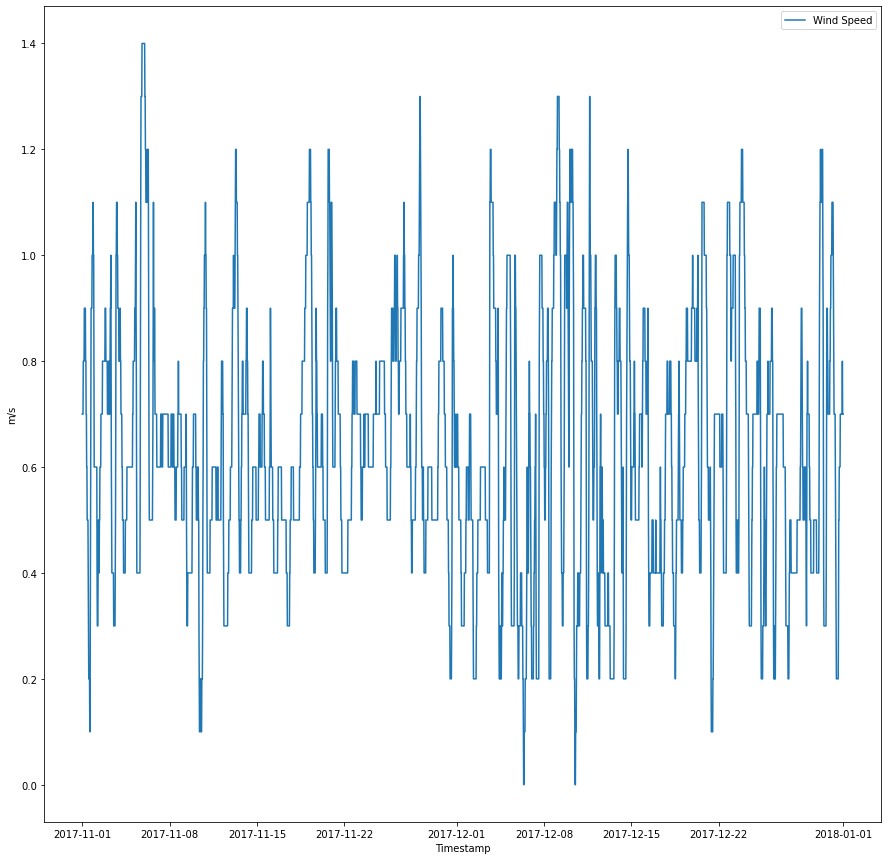

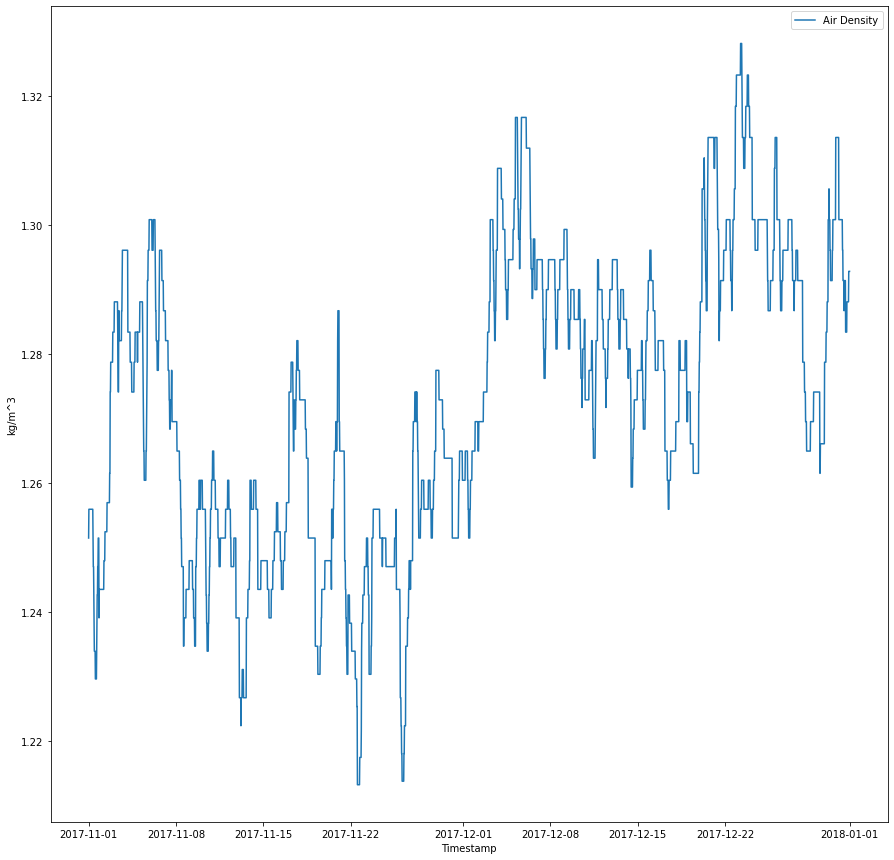

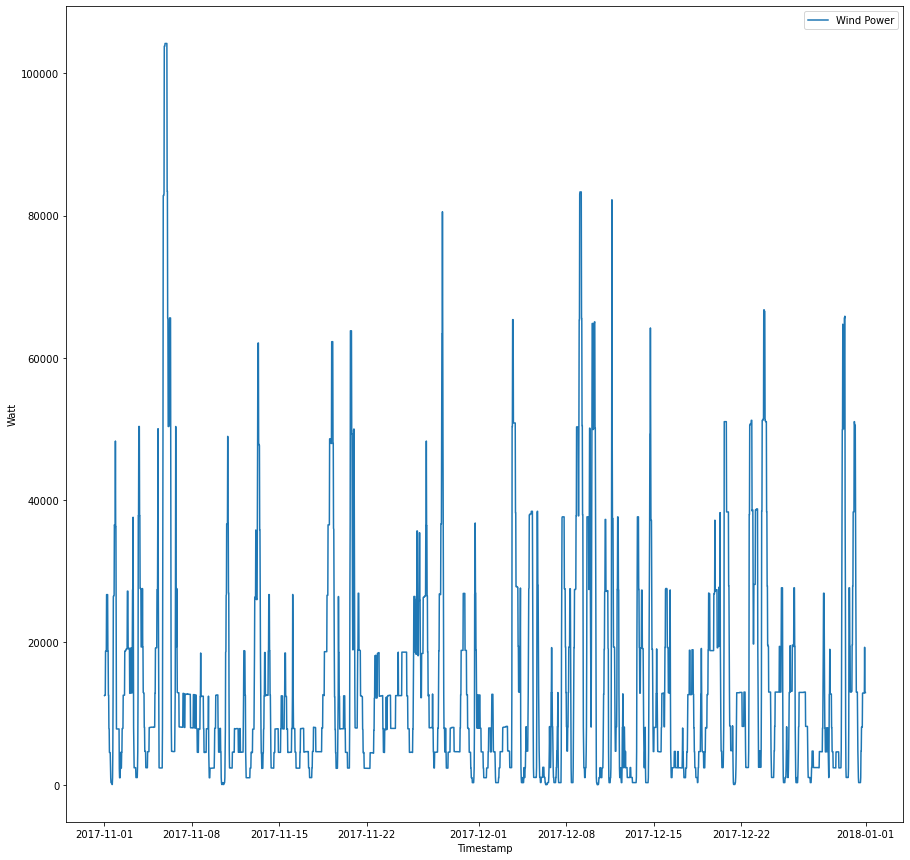

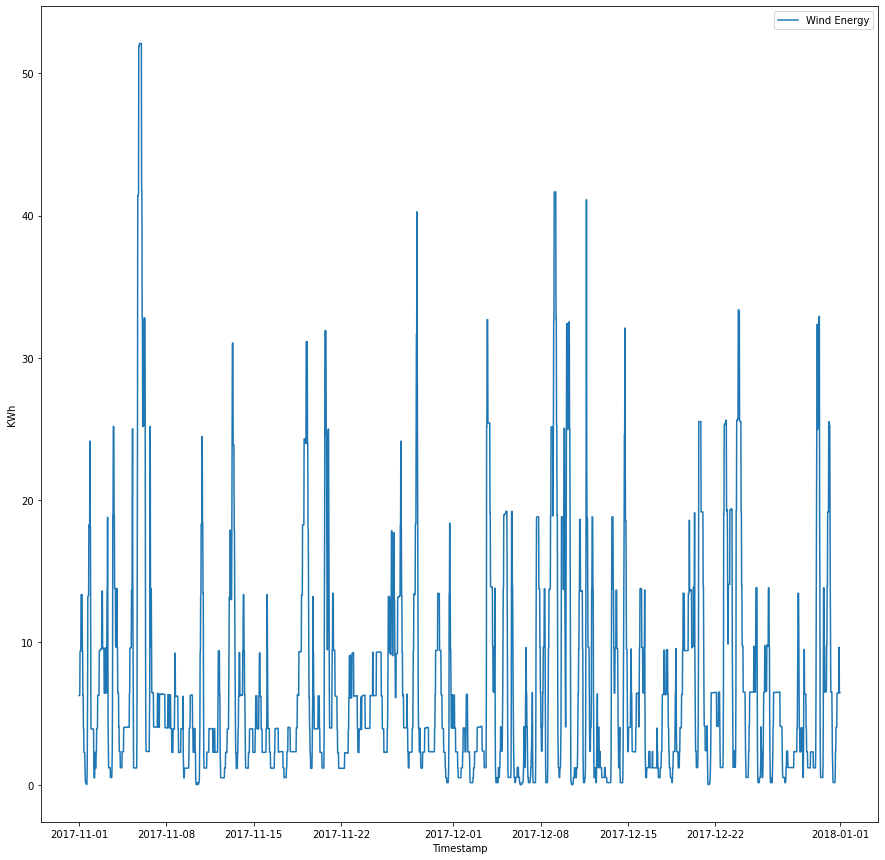

In [19]:
# Plotting line graphs for December 2017
figs, axs = plot_wind(wind_df, wind_feature_units, (15,15))

In [20]:
# Aggregating data points at every 6 hours
wind_df
wind_six_hour_df = wind_df.resample('6H').sum()
wind_six_hour_df

Pressure  Temperature  Wind Speed  Air Density  \
timestamp                                                             
2017-11-01 00:00:00   1212000       3362.8         9.6    15.066542   
2017-11-01 06:00:00   1212000       3383.8         7.5    14.973707   
2017-11-01 12:00:00   1212000       3418.8         4.6    14.820077   
2017-11-01 18:00:00   1204000       3367.8        10.9    14.944804   
2017-11-02 00:00:00   1200000       3360.8         6.4    14.926246   
...                       ...          ...         ...          ...   
2017-12-30 18:00:00   1230000       3277.8         9.1    15.686796   
2017-12-31 00:00:00   1230000       3277.8        12.2    15.686796   
2017-12-31 06:00:00   1224000       3283.8         5.9    15.581874   
2017-12-31 12:00:00   1220000       3298.8         4.7    15.460146   
2017-12-31 18:00:00   1212000       3274.8         8.5    15.471467   

                        Wind Power  Wind Energy  
timestamp                                        
2017-11-01 00:00:00  232205.460308   116.102730  
2017-11-01 06:00:00  125560.858541    62.780429  
2017-11-01 12:00:00   73094.389789    36.547195  
2017-11-01 18:00:00  353817.740973   176.908870  
2017-11-02 00:00:00   74839.098677    37.419549  
...                            ...          ...  
2017-12-30 18:00:00  206012.516822   103.006258  
2017-12-31 00:00:00  492105.402604   246.052701  
2017-12-31 06:00:00   82417.630954    41.208815  
2017-12-31 12:00:00   44310.655171    22.155328  
2017-12-31 18:00:00  161260.496105    80.630248  

[244 rows x 6 columns]

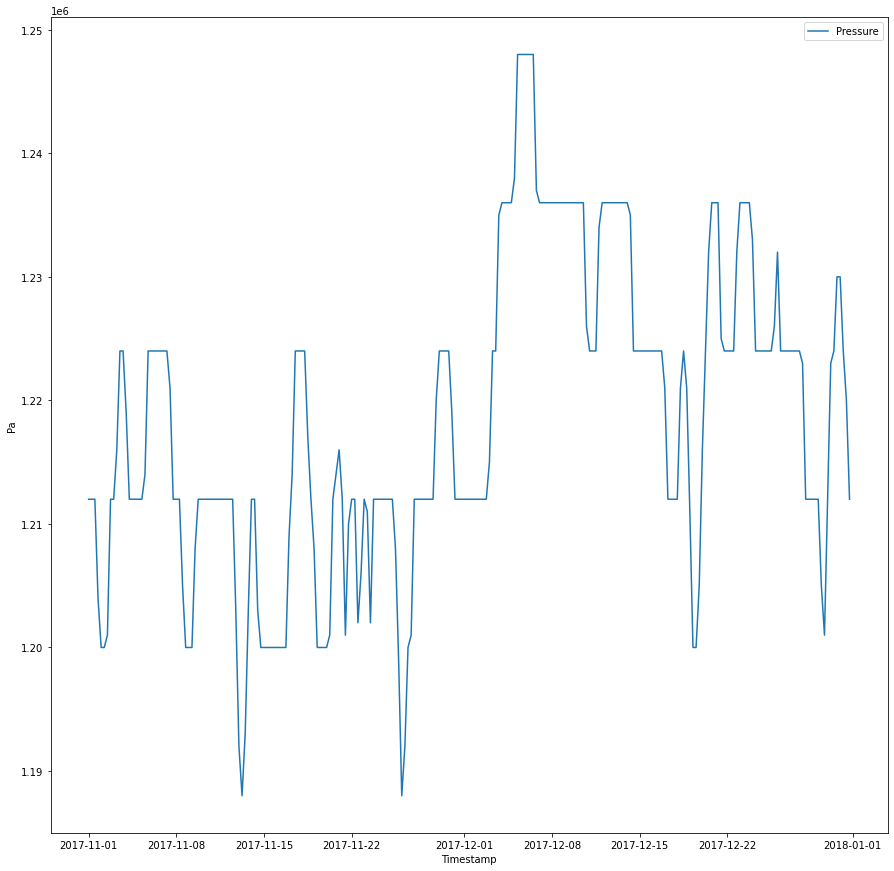

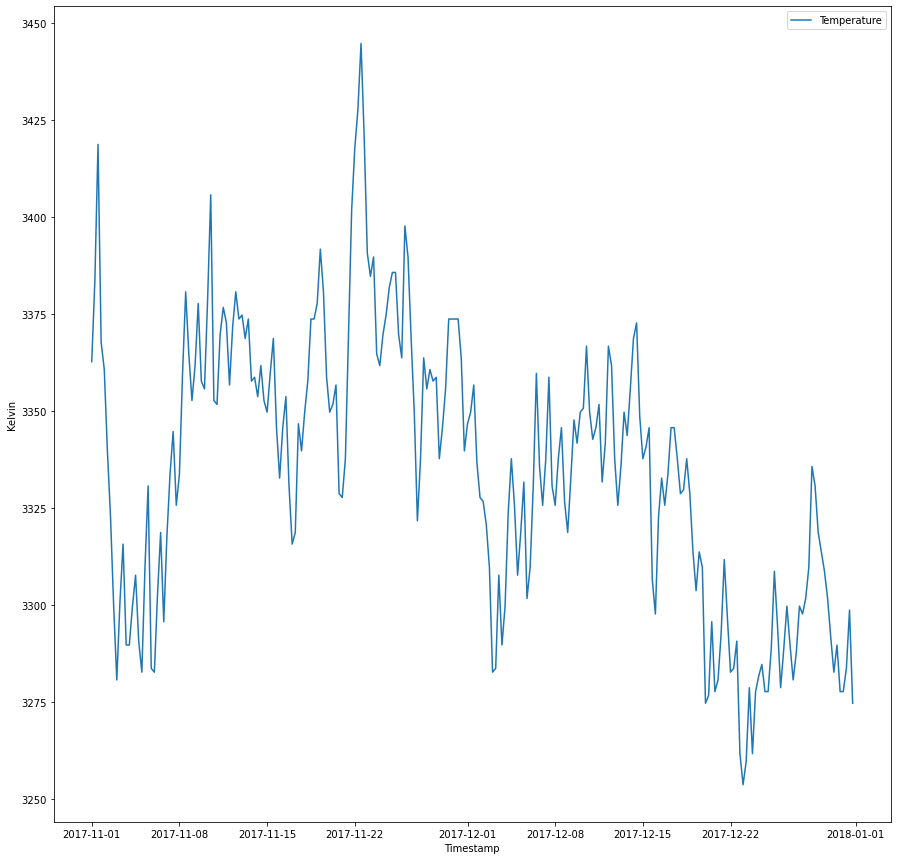

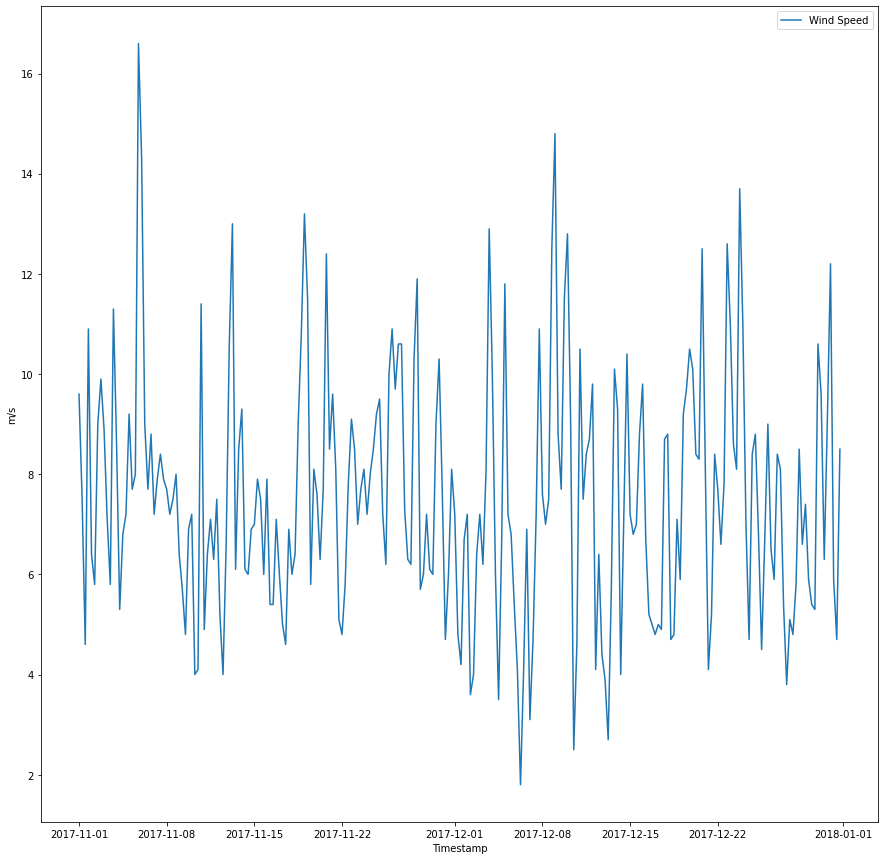

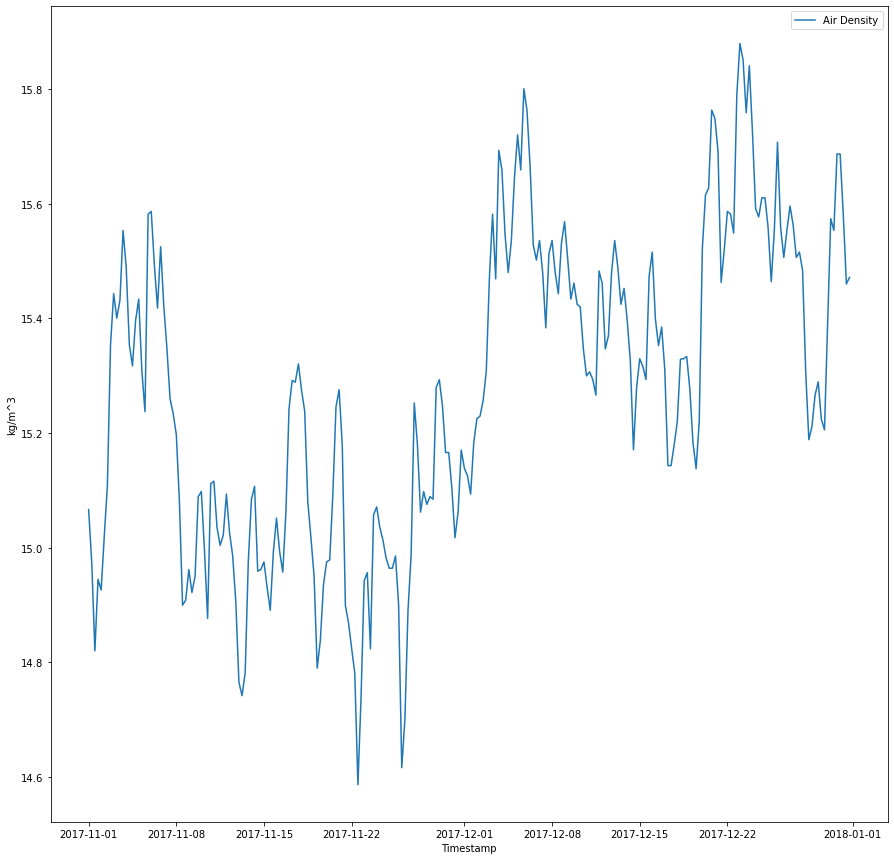

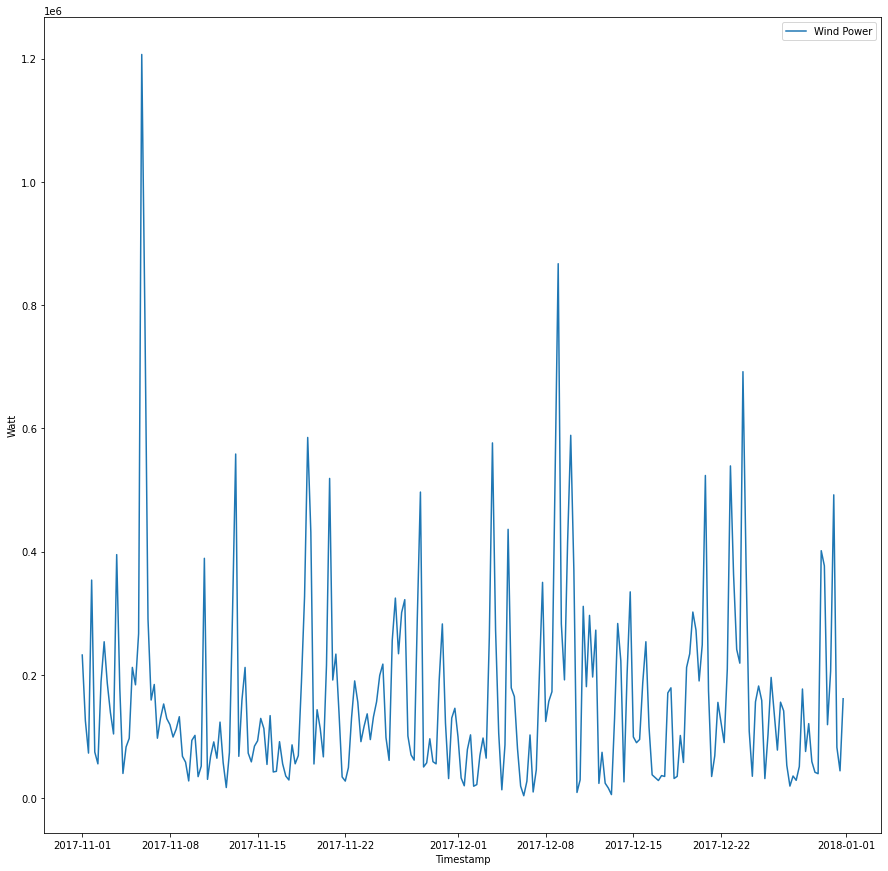

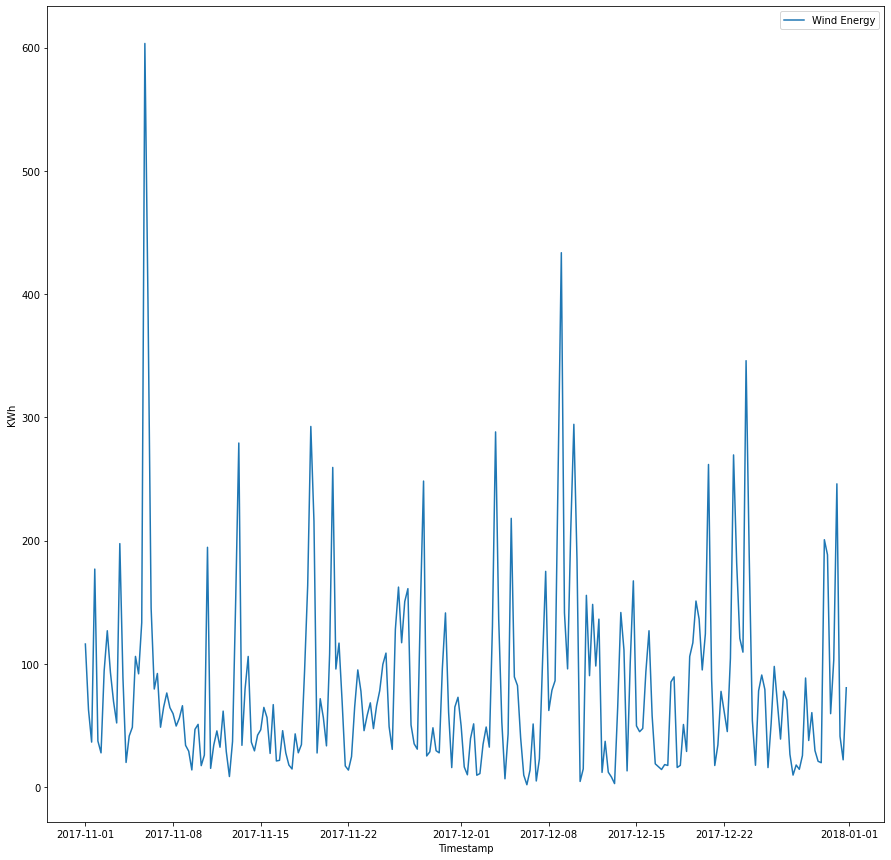

In [21]:
# Plotting line graphs for December 2017
figs, axs = plot_wind(wind_six_hour_df, wind_feature_units, (15,15))

# Energy Generation vs Energy Consumption annual graph

In [22]:
# Houses 4, 2, 3, and 15 belong to 4 separate clusters

In [23]:
consumption_df = pd.read_csv('Final Datasets/energy_consumption.csv')
consumption_df

Unnamed: 0            timestamp  energy_kWh  House Number  \
0                0  2012-06-01 01:00:00      1.0110             1   
1                1  2012-06-01 02:00:00      0.4510             1   
2                2  2012-06-01 03:00:00      0.5050             1   
3                3  2012-06-01 04:00:00      0.4410             1   
4                4  2012-06-01 05:00:00      0.4680             1   
...            ...                  ...         ...           ...   
611013      123761  2020-05-19 19:00:00      3.5802            28   
611014      123762  2020-05-19 20:00:00      3.4398            28   
611015      123763  2020-05-19 21:00:00      2.3049            28   
611016      123764  2020-05-19 22:00:00      2.4921            28   
611017      123765  2020-05-19 23:00:00      1.1817            28   

        electronics workbench energy  network equipment energy  \
0                           0.008686                  0.019316   
1                           0.007178                  0.019338   
2                           0.007324                  0.019336   
3                           0.007151                  0.019339   
4                           0.007224                  0.019338   
...                              ...                       ...   
611013                      0.028408                  0.038470   
611014                      0.027762                  0.038479   
611015                      0.022537                  0.038556   
611016                      0.023399                  0.038544   
611017                      0.017367                  0.038632   

        home office energy  RAE home office energy  \
0                 0.018232                0.134570   
1                 0.013745                0.061839   
2                 0.014177                0.068852   
3                 0.013664                0.060540   
4                 0.013881                0.064047   
...                    ...                     ...   
611013            0.069307                0.801381   
611014            0.067384                0.770210   
611015            0.051836                0.518247   
611016            0.054401                0.559808   
611017            0.036449                0.268881   

        RAE Mobile Phone Charger Energy  
0                              0.000431  
1                              0.000215  
2                              0.000236  
3                              0.000211  
4                              0.000221  
...                                 ...  
611013                         0.002441  
611014                         0.002348  
611015                         0.001601  
611016                         0.001724  
611017                         0.000861  

[611018 rows x 9 columns]

In [24]:
if 'Unnamed: 0' in consumption_df.columns:
    consumption_df.drop('Unnamed: 0',axis=1, inplace = True)

generation_df = pd.read_csv('Final Datasets/energy_generation.csv')
generation_df['Energy Generation'] = generation_df['Wind Energy'] + generation_df['Solar Energy']
generation_df = generation_df[['timestamp', 'Energy Generation']].set_index('timestamp')
generation_df

Energy Generation
timestamp                             
2012-01-01 00:00:00           0.168265
2012-01-01 01:00:00           0.168265
2012-01-01 02:00:00           0.168265
2012-01-01 03:00:00           0.168265
2012-01-01 04:00:00           0.168265
...                                ...
2020-12-31 19:00:00           1.710441
2020-12-31 20:00:00           1.710441
2020-12-31 21:00:00           1.497873
2020-12-31 22:00:00           1.285454
2020-12-31 23:00:00           1.286778

[78912 rows x 1 columns]

In [25]:
house_4 = consumption_df[consumption_df['House Number'] == 4][['timestamp', 'energy_kWh']]
house_2 = consumption_df[consumption_df['House Number'] == 2][['timestamp', 'energy_kWh']]
house_3 = consumption_df[consumption_df['House Number'] == 3][['timestamp', 'energy_kWh']]
house_15 = consumption_df[consumption_df['House Number'] == 15][['timestamp', 'energy_kWh']]

house_4= house_4[(house_4['timestamp'] <= '2018-01-01') & (house_4['timestamp'] >= '2017-01-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})

house_2= house_2[(house_2['timestamp'] <= '2018-01-01') & (house_2['timestamp'] >= '2017-01-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_3= house_3[(house_3['timestamp'] <= '2018-01-01') & (house_3['timestamp'] >= '2017-01-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_15= house_15[(house_15['timestamp'] <= '2018-01-01') & (house_15['timestamp'] >= '2017-01-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_15

Energy Consumption  Energy Generation
timestamp                                                 
2017-01-01 00:00:00                0.28           0.462231
2017-01-01 01:00:00                0.24           0.462231
2017-01-01 02:00:00                0.24           0.689978
2017-01-01 03:00:00                0.22           0.688715
2017-01-01 04:00:00                7.18           0.687452
...                                 ...                ...
2017-12-31 19:00:00                4.38           0.460539
2017-12-31 20:00:00                3.92           0.460539
2017-12-31 21:00:00                3.98           0.460539
2017-12-31 22:00:00                3.94           0.576104
2017-12-31 23:00:00                0.20           0.462231

[8729 rows x 2 columns]

In [26]:
house_4['timestamp'] = pd.to_datetime(house_4.index)
house_2['timestamp'] = pd.to_datetime(house_2.index)
house_3['timestamp'] = pd.to_datetime(house_3.index)
house_15['timestamp'] = pd.to_datetime(house_15.index)
# house_4['timestamp'] = house_4['timestamp'] + pd.offsets.DateOffset(years=3)
# house_2['timestamp'] = house_2['timestamp'] + pd.offsets.DateOffset(years=3)
# house_3['timestamp'] = house_3['timestamp'] + pd.offsets.DateOffset(years=3)
# house_15['timestamp'] = house_15['timestamp'] + pd.offsets.DateOffset(years=3)
house_4 = house_4.set_index('timestamp')
house_2 = house_2.set_index('timestamp')
house_3 = house_3.set_index('timestamp')
house_15 = house_15.set_index('timestamp')
house_4

Energy Consumption  Energy Generation
timestamp                                                 
2017-01-01 00:00:00                1.57           0.462231
2017-01-01 01:00:00                1.51           0.462231
2017-01-01 02:00:00                1.08           0.689978
2017-01-01 03:00:00                1.04           0.688715
2017-01-01 04:00:00                0.88           0.687452
...                                 ...                ...
2017-12-31 19:00:00                1.95           0.460539
2017-12-31 20:00:00                1.57           0.460539
2017-12-31 21:00:00                1.57           0.460539
2017-12-31 22:00:00                1.29           0.576104
2017-12-31 23:00:00                1.22           0.462231

[8745 rows x 2 columns]

Text(0, 0.5, 'kWh')

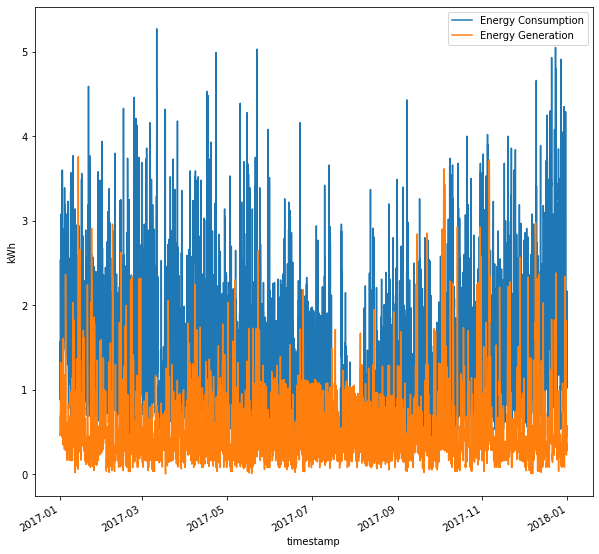

In [27]:
ax = house_4.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

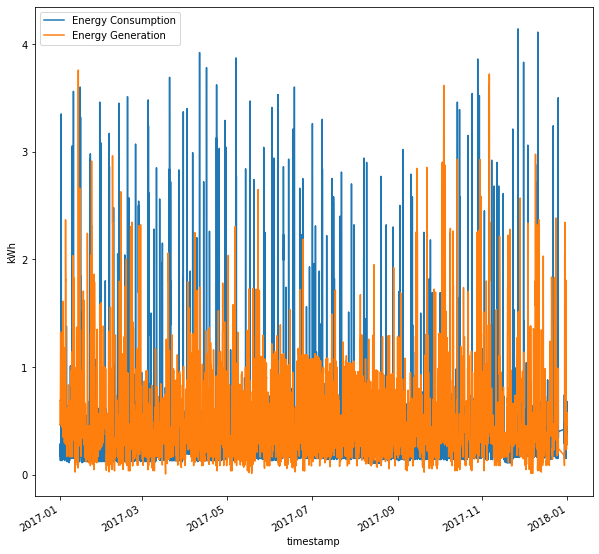

In [28]:
ax = house_2.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

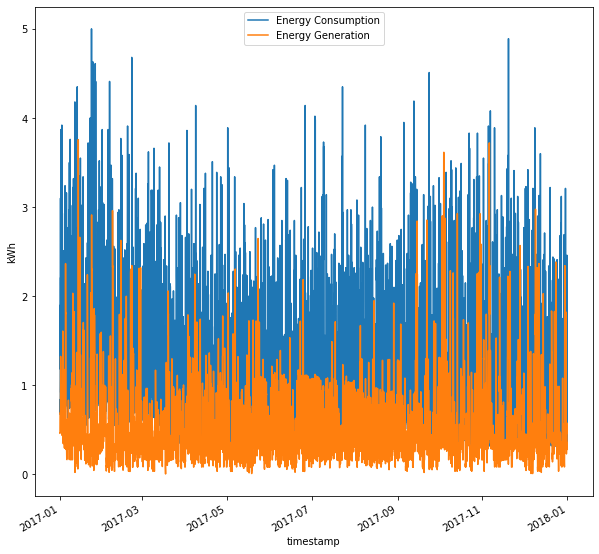

In [29]:
ax = house_3.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

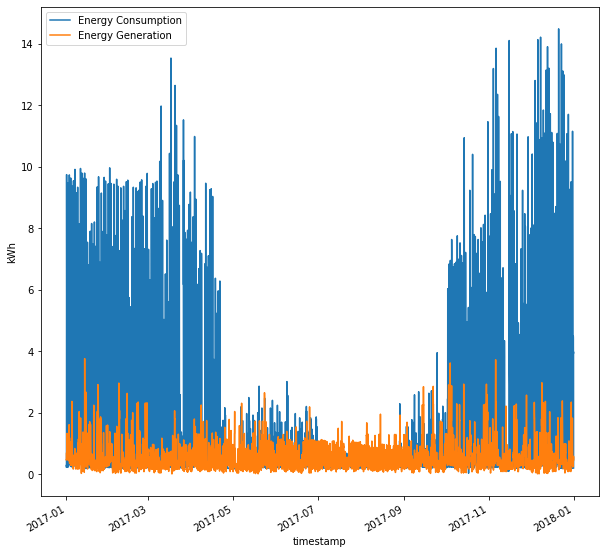

In [30]:
ax = house_15.plot(figsize=(10,10))
ax.set_ylabel('kWh')

In [31]:
house_4['ts'] = pd.to_datetime(house_4.index)
#house_4['ts'] = house_4['ts'] + pd.offsets.DateOffset(years=3)
house_4.set_index('ts', inplace=True)

house_2['ts'] = pd.to_datetime(house_2.index)
#house_2['ts'] = house_2['ts'] + pd.offsets.DateOffset(years=3)
house_2.set_index('ts', inplace=True)

house_3['ts'] = pd.to_datetime(house_3.index)
#house_3['ts'] = house_3['ts'] + pd.offsets.DateOffset(years=3)
house_3.set_index('ts', inplace=True)

house_15['ts'] = pd.to_datetime(house_15.index)
#house_15['ts'] = house_15['ts'] + pd.offsets.DateOffset(years=3)
house_15.set_index('ts', inplace=True)

house_15

Energy Consumption  Energy Generation
ts                                                        
2017-01-01 00:00:00                0.28           0.462231
2017-01-01 01:00:00                0.24           0.462231
2017-01-01 02:00:00                0.24           0.689978
2017-01-01 03:00:00                0.22           0.688715
2017-01-01 04:00:00                7.18           0.687452
...                                 ...                ...
2017-12-31 19:00:00                4.38           0.460539
2017-12-31 20:00:00                3.92           0.460539
2017-12-31 21:00:00                3.98           0.460539
2017-12-31 22:00:00                3.94           0.576104
2017-12-31 23:00:00                0.20           0.462231

[8729 rows x 2 columns]

In [32]:
# Resampling to daily values
house_4_daily = house_4.resample('D').sum()
house_2_daily = house_2.resample('D').sum()
house_3_daily = house_3.resample('D').sum()
house_15_daily = house_15.resample('D').sum()
house_4_daily

Energy Consumption  Energy Generation
ts                                               
2017-01-01               43.40          19.422454
2017-01-02               54.41          18.228269
2017-01-03               45.50          17.220156
2017-01-04               56.63          15.468864
2017-01-05               50.39          20.909048
...                        ...                ...
2017-12-27               53.58           6.046977
2017-12-28               52.00           7.521295
2017-12-29               42.64           6.234746
2017-12-30               38.50          21.432941
2017-12-31               40.41          15.667253

[365 rows x 2 columns]

Text(0, 0.5, 'kWh')

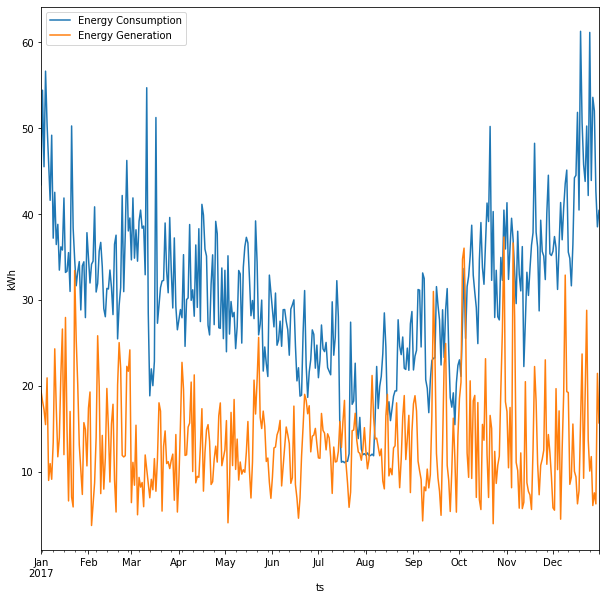

In [33]:
ax = house_4_daily.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

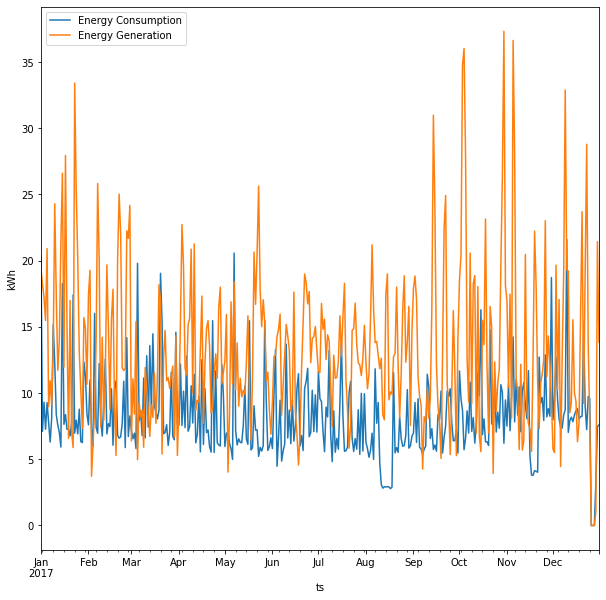

In [34]:
ax = house_2_daily.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

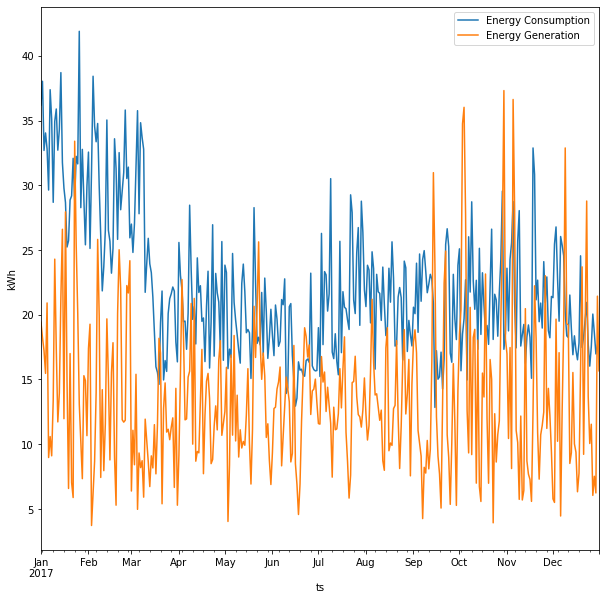

In [35]:
ax = house_3_daily.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

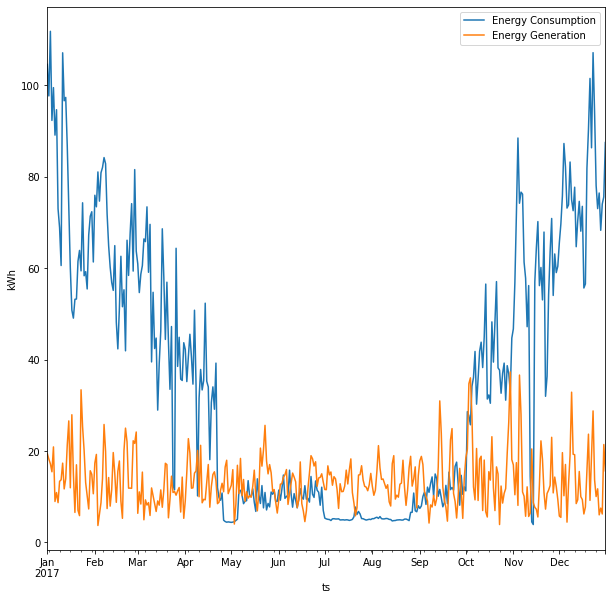

In [36]:
ax = house_15_daily.plot(figsize=(10,10))
ax.set_ylabel('kWh')

In [37]:
# Resampling to Weekly values

In [38]:
house_4_weekly = house_4.resample('W').sum()
house_2_weekly = house_2.resample('W').sum()
house_3_weekly = house_3.resample('W').sum()
house_15_weekly = house_15.resample('W').sum()
#house_4_weekly

Text(0, 0.5, 'kWh')

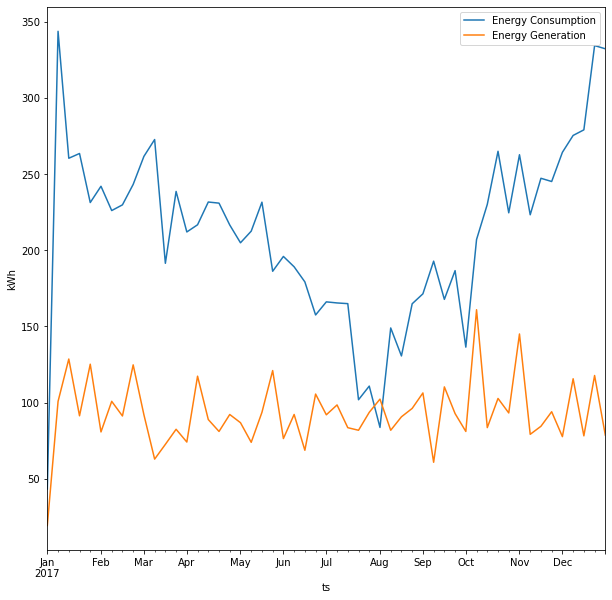

In [39]:
ax = house_4_weekly.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

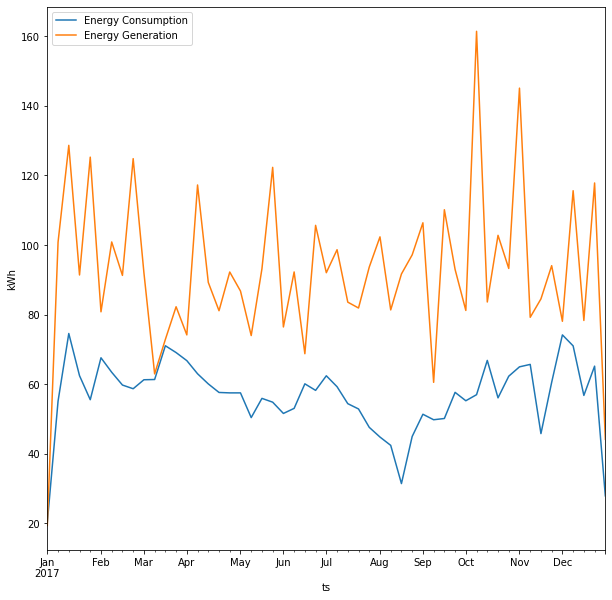

In [40]:
ax = house_2_weekly.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

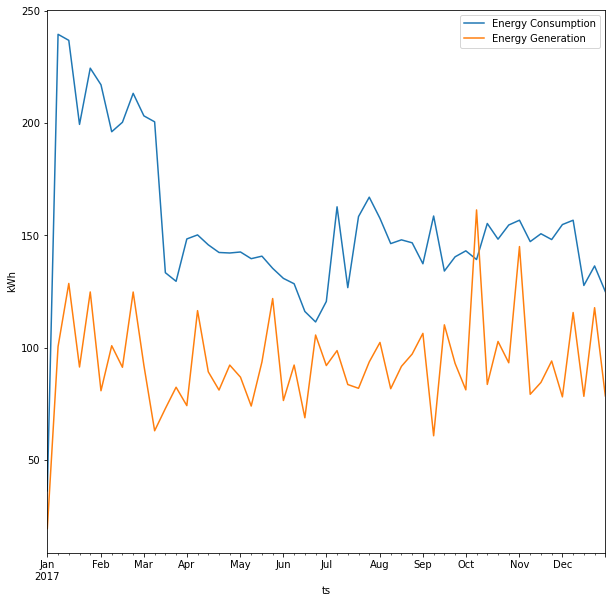

In [41]:
ax = house_3_weekly.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

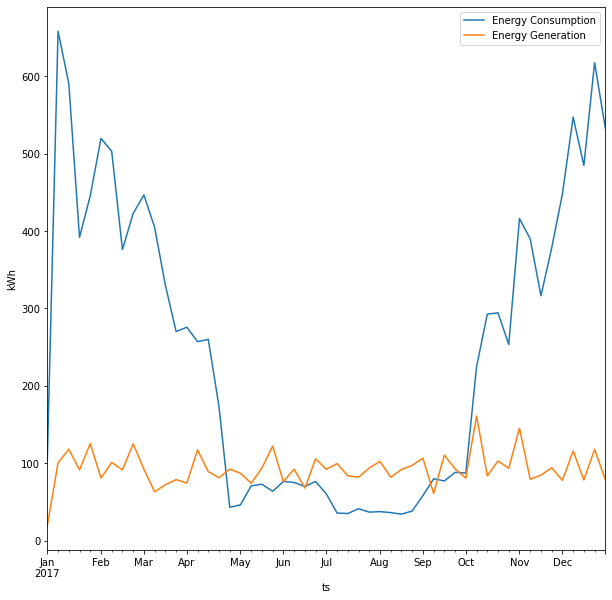

In [42]:
ax = house_15_weekly.plot(figsize=(10,10))
ax.set_ylabel('kWh')

## Energy Generation vs Energy Consumption graph for a month

In [43]:
house_4 = consumption_df[consumption_df['House Number'] == 4][['timestamp', 'energy_kWh']]
house_2 = consumption_df[consumption_df['House Number'] == 2][['timestamp', 'energy_kWh']]
house_3 = consumption_df[consumption_df['House Number'] == 3][['timestamp', 'energy_kWh']]
house_15 = consumption_df[consumption_df['House Number'] == 15][['timestamp', 'energy_kWh']]

house_4= house_4[(house_4['timestamp'] <= '2017-12-01') & (house_4['timestamp'] >= '2017-11-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_2= house_2[(house_2['timestamp'] <= '2017-12-01') & (house_2['timestamp'] >= '2017-11-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_3= house_3[(house_3['timestamp'] <= '2017-12-01') & (house_3['timestamp'] >= '2017-11-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})
house_15= house_15[(house_15['timestamp'] <= '2017-12-01') & (house_15['timestamp'] >= '2017-11-01')].set_index('timestamp').join(generation_df).rename(columns = {'energy_kWh': 'Energy Consumption'})

house_4['ts'] = pd.to_datetime(house_4.index)
# house_4['ts'] = house_4['ts'] + pd.offsets.DateOffset(years=3)
house_4.set_index('ts', inplace=True)

house_2['ts'] = pd.to_datetime(house_2.index)
# house_2['ts'] = house_2['ts'] + pd.offsets.DateOffset(years=3)
house_2.set_index('ts', inplace=True)

house_3['ts'] = pd.to_datetime(house_3.index)
# house_3['ts'] = house_3['ts'] + pd.offsets.DateOffset(years=3)
house_3.set_index('ts', inplace=True)

house_15['ts'] = pd.to_datetime(house_15.index)
# house_15['ts'] = house_15['ts'] + pd.offsets.DateOffset(years=3)
house_15.set_index('ts', inplace=True)

house_4

Energy Consumption  Energy Generation
ts                                                        
2017-11-01 00:00:00                0.90           0.448233
2017-11-01 01:00:00                0.77           0.449032
2017-11-01 02:00:00                0.83           0.670275
2017-11-01 03:00:00                0.87           0.670275
2017-11-01 04:00:00                1.01           0.954356
...                                 ...                ...
2017-11-30 19:00:00                1.65           0.563677
2017-11-30 20:00:00                1.35           0.284805
2017-11-30 21:00:00                1.44           0.284805
2017-11-30 22:00:00                1.30           0.368533
2017-11-30 23:00:00                1.05           0.283785

[720 rows x 2 columns]

In [44]:
# Resample to 4 hours
house_4_4h = house_4.resample('4H').sum()
house_2_4h = house_2.resample('4H').sum()
house_3_4h= house_3.resample('4H').sum()
house_15_4h = house_15.resample('4H').sum()

Text(0, 0.5, 'kWh')

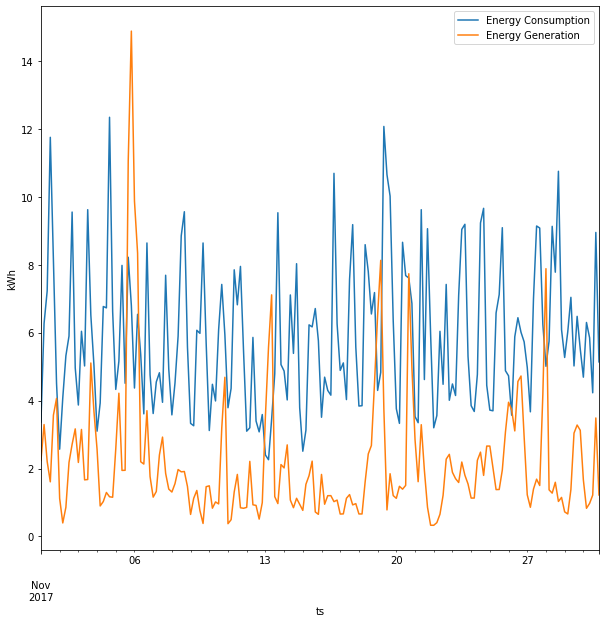

In [45]:
ax = house_4_4h.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

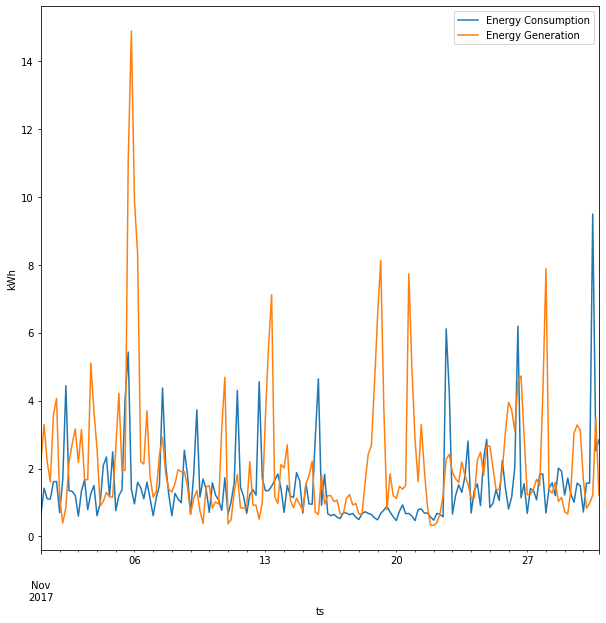

In [46]:
ax = house_2_4h.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

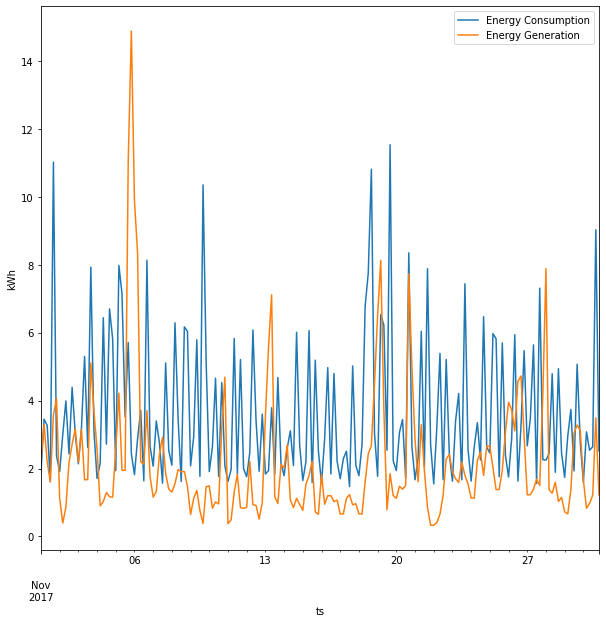

In [47]:
ax = house_3_4h.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

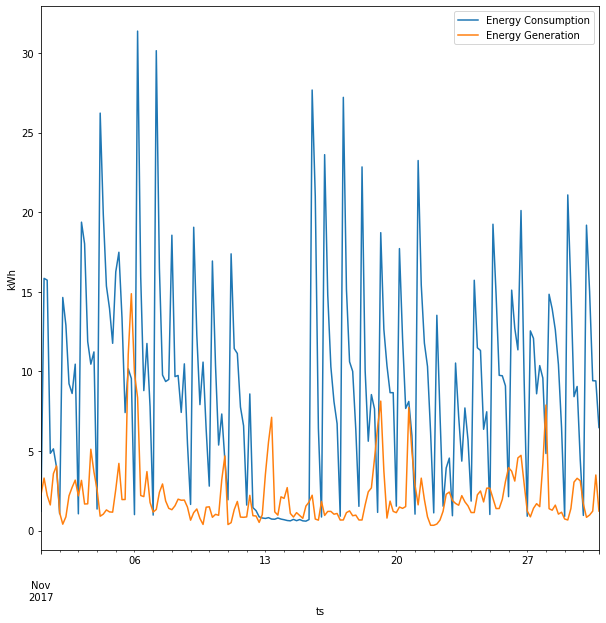

In [48]:
ax = house_15_4h.plot(figsize=(10,10))
ax.set_ylabel('kWh')

In [49]:
# Resample to 1 day
house_4 = house_4.resample('D').sum()
house_2 = house_2.resample('D').sum()
house_3= house_3.resample('D').sum()
house_15 = house_15.resample('D').sum()

Text(0, 0.5, 'kWh')

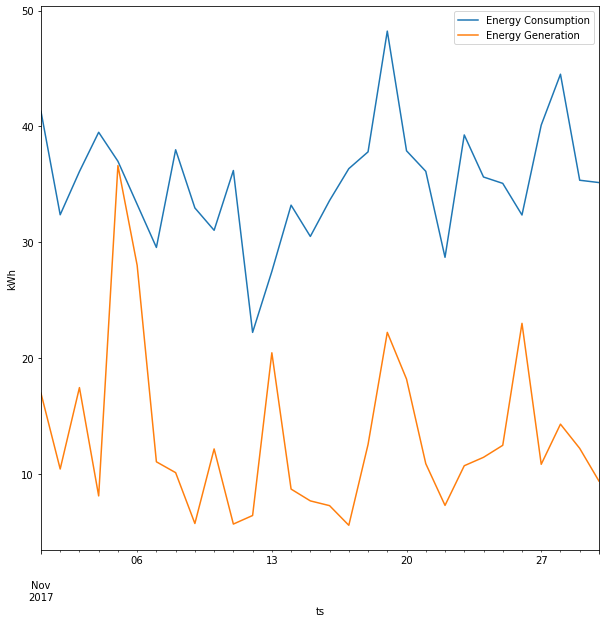

In [50]:
ax = house_4.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

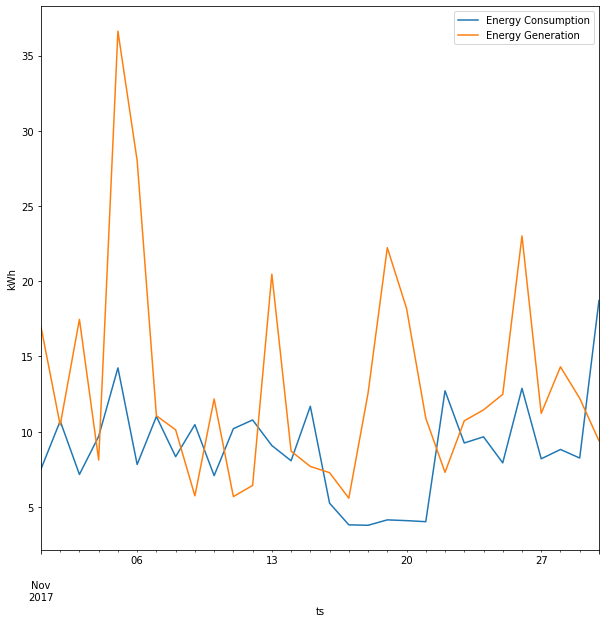

In [51]:
ax = house_2.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

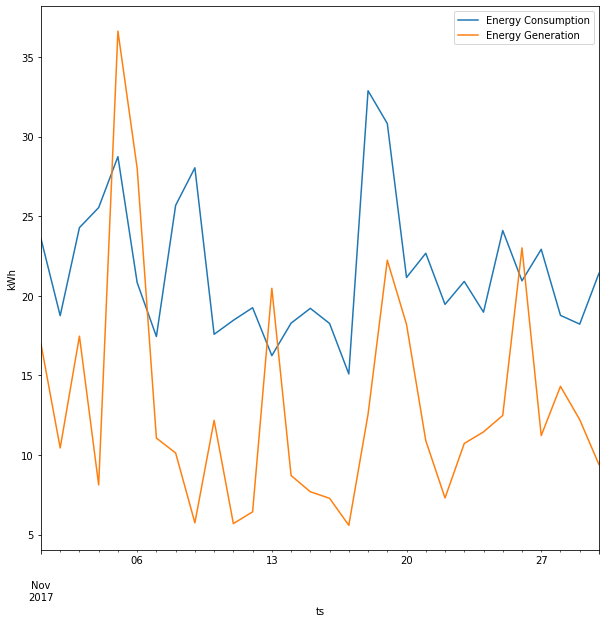

In [52]:
ax = house_3.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

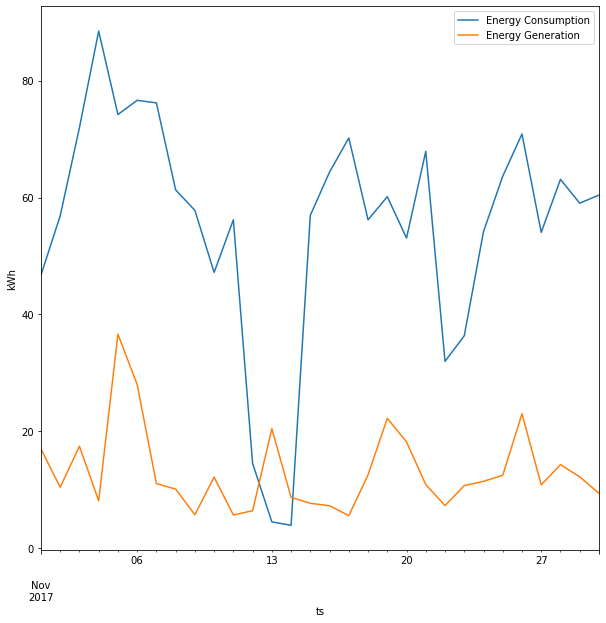

In [53]:
ax = house_15.plot(figsize=(10,10))
ax.set_ylabel('kWh')

# Wind Energy vs Solar Energy Generation annual graph

In [54]:
generation_df = pd.read_csv('Final Datasets/energy_generation.csv')
generation_df = generation_df[(generation_df['timestamp'] <= '2018-01-01') & (generation_df['timestamp'] >= '2017-01-01')].set_index('timestamp')

In [55]:
#generation_df

Text(0, 0.5, 'kWh')

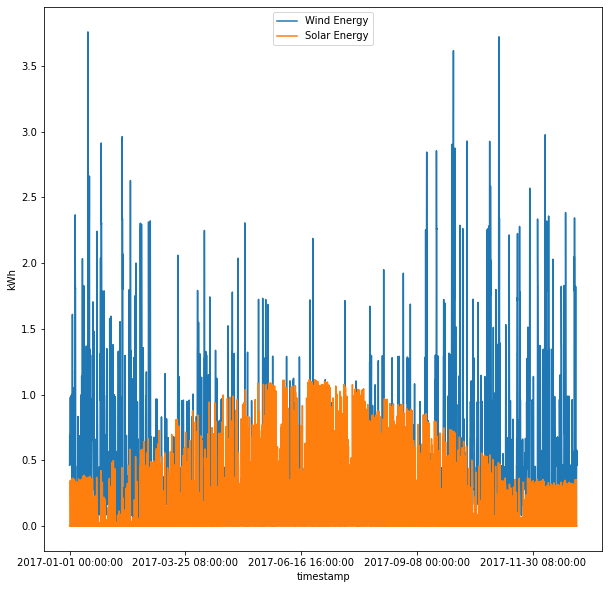

In [56]:
ax = generation_df.plot(figsize=(10,10))
ax.set_ylabel('kWh')

Text(0, 0.5, 'kWh')

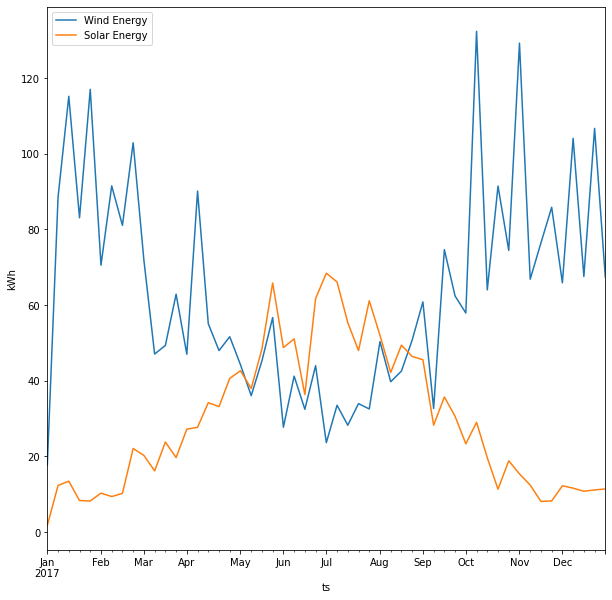

In [57]:
generation_df['ts'] = pd.to_datetime(generation_df.index)
generation_df.set_index('ts', inplace=True)

# Resample to 1 week

generation_df = generation_df.resample('W').sum()
ax = generation_df.plot(figsize=(10,10))
ax.set_ylabel('kWh')

## Wind Energy vs Solar Energy Generation graph for a month

In [58]:
generation_df = pd.read_csv('Final Datasets/energy_generation.csv')
generation_df = generation_df[(generation_df['timestamp'] <= '2017-12-01') & (generation_df['timestamp'] >= '2017-11-01')].set_index('timestamp')

In [59]:
generation_df['ts'] = pd.to_datetime(generation_df.index)
generation_df.set_index('ts', inplace=True)
generation_df

Wind Energy  Solar Energy
ts                                            
2017-11-01 00:00:00     0.448233           0.0
2017-11-01 01:00:00     0.449032           0.0
2017-11-01 02:00:00     0.670275           0.0
2017-11-01 03:00:00     0.670275           0.0
2017-11-01 04:00:00     0.954356           0.0
...                          ...           ...
2017-11-30 19:00:00     0.563677           0.0
2017-11-30 20:00:00     0.284805           0.0
2017-11-30 21:00:00     0.284805           0.0
2017-11-30 22:00:00     0.368533           0.0
2017-11-30 23:00:00     0.283785           0.0

[720 rows x 2 columns]

Text(0, 0.5, 'kWh')

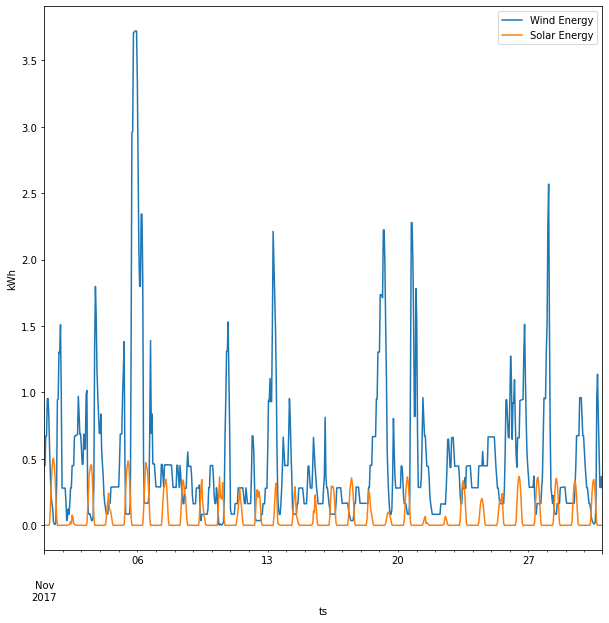

In [60]:
ax = generation_df.plot(figsize=(10,10))
ax.set_ylabel('kWh')

# Comparing scenarios against real energy consumption for a house in each cluster

In [61]:
# all_cluster_results_file = open("Models/Scenario2/Objects/all_cluster_results.pickle", "rb")
# all_cluster_results = pickle.load( all_cluster_results_file)
# all_cluster_results_file.close()


# scenario_4_all_cluster_results_file = open("Models/Scenario4/Objects/all_cluster_results.pickle", "rb")
# scenario_4_all_cluster_results=pickle.load(scenario_4_all_cluster_results_file)
# scenario_4_all_cluster_results_file.close()